In [147]:
#import modules
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
import umap
import copy

In [148]:
#load the data and subset only the required columns
basepath = "C:/Users/ashuk/Desktop/MLProject/ashrae-energy-prediction/"
train = pd.read_csv(basepath + "train.csv")
building = pd.read_csv(basepath + "building_metadata.csv")
train = pd.merge(train, building, left_on="building_id", right_on="building_id", how="left")
train = train[['building_id','timestamp', 'meter', 'meter_reading', 'primary_use']]
del building

## Section for some custom functions that are to be used frequently.

In [149]:
color_values = ["red", "green","brown","purple","cyan"]
def plot_tsne(X,pivot=None, alpha=0.6, xlabel="x-axis", ylabel="y-axis", title="Dimension reduced by t-SNE"):
    plt.figure(figsize=(20,10))
    tsne = TSNE()
    results_tsne = tsne.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(results_tsne[:,0], results_tsne[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
    )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return
def plot_isomap(X,pivot=None, alpha=0.6, neighbor = 8, dimension=2, xlabel="x-axis", ylabel="y-axis", title="Dimension reduced by ISOMAP"):
    plt.figure(figsize=(20,10))
    isomap = Isomap(n_components=dimension, n_neighbors=neighbor)
    results_isomap = isomap.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(results_isomap[:,0], results_isomap[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
        )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return
def plot_umap(X,pivot=None, neighbor = 8, dimension=2, alpha=0.6, xlabel="x-axis", ylabel="y-axis", title="Dimension reduced by UMAP"):
    plt.figure(figsize=(20,10))
    reducer = umap.UMAP(n_neighbors=neighbor, n_components=dimension)
    umap_result = reducer.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(umap_result[:,0], umap_result[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
        )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return

def plot_kernel_pca(X, pivot=None, kernel="rbf", esolver="auto", rzev = True, g = 15, deg = None, title="Representation obtained usinf Kernel PCA"):
    plt.figure(figsize=(20,10))
    if deg is not None:
        kpca = KernelPCA(n_components=2, n_jobs=-1, eigen_solver=esolver, remove_zero_eig=rzev, gamma=g, kernel=kernel, degree=deg)
    else:
        kpca = KernelPCA(n_components=2, n_jobs=-1, eigen_solver=esolver, remove_zero_eig=rzev, gamma=g, kernel=kernel)
    
    kpca_result = kpca.fit_transform(X)
    cluster_values = sorted(pivot.index.get_level_values("cluster").unique())
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_values)
    plt.scatter(kpca_result[:,0], kpca_result[:,1],
        c=pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.6, 
        )
    plt.title(title)
    plt.xlabel("x-axis")
    plt.ylabel("y-axis")
    return

In [150]:
def perform_clustering_quarter_wise(quarter_no=1, train = None, drop_columns=None):
    
    quarter1 = copy.deepcopy(train)
    if quarter_no>0:
        quarter1["quarter"] = quarter1["timestamp"].dt.quarter
        quarter1 = quarter1[quarter1["quarter"]==quarter_no]
    quarter1["meter_reading"].fillna(0, inplace=True)
    
    if quarter_no>0:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    else:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot(values="meter_reading", index="building_id", columns="timestamp")
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    #perHourElectricityConsumptionEachBuildingQ1.drop(perHourElectricityConsumptionEachBuildingQ1.index[[1100,779,1198,1089,1022,1169,1160,1149,1285]], inplace=True)
    perHourElectricityConsumptionEachBuildingQ1.head(5)
    if drop_columns is not None:
        perHourElectricityConsumptionEachBuildingQ1.drop(perHourElectricityConsumptionEachBuildingQ1.index[drop_columns], inplace=True)
    
    XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuildingQ1.values.copy())
    XQ1
    
    silhouette_scores_q1 = list()
    inertia = list()
    no_cluster = np.arange(2,28).astype("int")
    for cluster in no_cluster:
        kmeansQ1 = KMeans(n_clusters=cluster, init="k-means++")
        c_f = kmeansQ1.fit_predict(XQ1)
        silhouette_scores_q1.append(silhouette_score(XQ1, kmeansQ1.labels_))
        inertia.append(kmeansQ1.inertia_)
    
    
    plt.figure(figsize=(20,10))
    plt.plot([i for i in range(0,26,1)], silhouette_scores_q1)
    plt.xticks([i for i in range(0,26,1)])
    plt.yticks(np.arange(0,1,0.1))
    plt.ylabel("silhouette score")
    plt.xlabel("cluster number")
    plt.grid()
    
    plt.figure(figsize=(20,10))
    plt.plot([i for i in range(1,27,1)], inertia)
    plt.xticks([i for i in range(1,27,1)])
    plt.ylabel("within cluster SSE")
    plt.xlabel("cluster number")
    plt.grid()
    kmeans = KMeans(n_clusters=3)
    cluster_found_q1 = kmeans.fit_predict(XQ1)
    cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
    perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)

    plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor=10, title="KMeans with euclidean distance")
    
    perHourElectricityConsumptionEachBuildingQ1.index = perHourElectricityConsumptionEachBuildingQ1.index.droplevel(-1)
    kmeansTslearn = TimeSeriesKMeans(n_clusters=3, max_iter=1000, metric="dtw", n_jobs=4, init="k-means++")
    cluster_found_q1 = kmeansTslearn.fit_predict(XQ1)
    cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
    perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)
    
    plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor = 10, title="KMeans with DTW distance")
    
    # printing the score of internal validation measures
    print("Internal Validation scores for quarter {}".format(quarter_no))
    print("silhouette score on euclidean metric: ",silhouette_score(XQ1, kmeans.labels_))
    print("silhouette score on dtw metric: ",silhouette_score(XQ1, kmeansTslearn.labels_))
    print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, kmeans.labels_))
    print("calsinki-H score on dtw metric: ",calinski_harabasz_score(XQ1, kmeansTslearn.labels_))
    print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, kmeans.labels_))
    print("davis-B score on dtw metric: ",davies_bouldin_score(XQ1, kmeansTslearn.labels_))
    return

### Extract only the meter readings for electricity (meter_type = 1)

In [151]:
train = train.loc[train["meter"]==2]

In [152]:
train = train[~train["building_id"].isin([1100,779,1198,1089,1022,1169,1160,1149,1285,1099])]

In [153]:
#convert timestamp in strin to type timestamp and set it as index of the dataframe.
train["timestamp"] = pd.to_datetime(train["timestamp"])
train.set_index(["timestamp"], inplace=True)

In [154]:
#check the shape of the extracted dataframe
print(train.shape)

(2648677, 4)


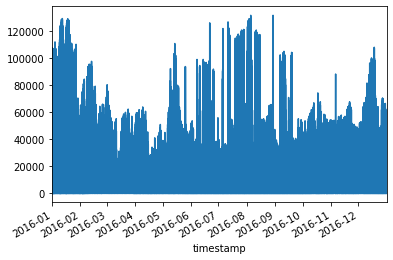

In [155]:
# simple plot  of meter readings over the whole year
train.loc[:, "meter_reading"].plot()

In [156]:
# summarizing electricity consumption over the whole year according to timestamp
summaryTimestampData = train.groupby([ "primary_use","timestamp"])["meter_reading"].agg("mean").reset_index()
summaryTimestampData.set_index(["primary_use"], inplace=True)
summaryTimestampData.set_index(["timestamp"], append=True, inplace=True)
summaryTimestampData

meter_reading
primary_use       timestamp                         
Education         2016-01-01 00:00:00    1369.297192
                  2016-01-01 01:00:00    1588.738822
                  2016-01-01 02:00:00    1498.814838
                  2016-01-01 03:00:00    1511.108902
                  2016-01-01 04:00:00    1532.131948
...                                              ...
Warehouse/storage 2016-12-31 19:00:00     269.287000
                  2016-12-31 20:00:00     240.723000
                  2016-12-31 21:00:00     288.086000
                  2016-12-31 22:00:00     251.953000
                  2016-12-31 23:00:00     277.588000

[120352 rows x 1 columns]

Text(0, 0.5, 'mean meter reading')

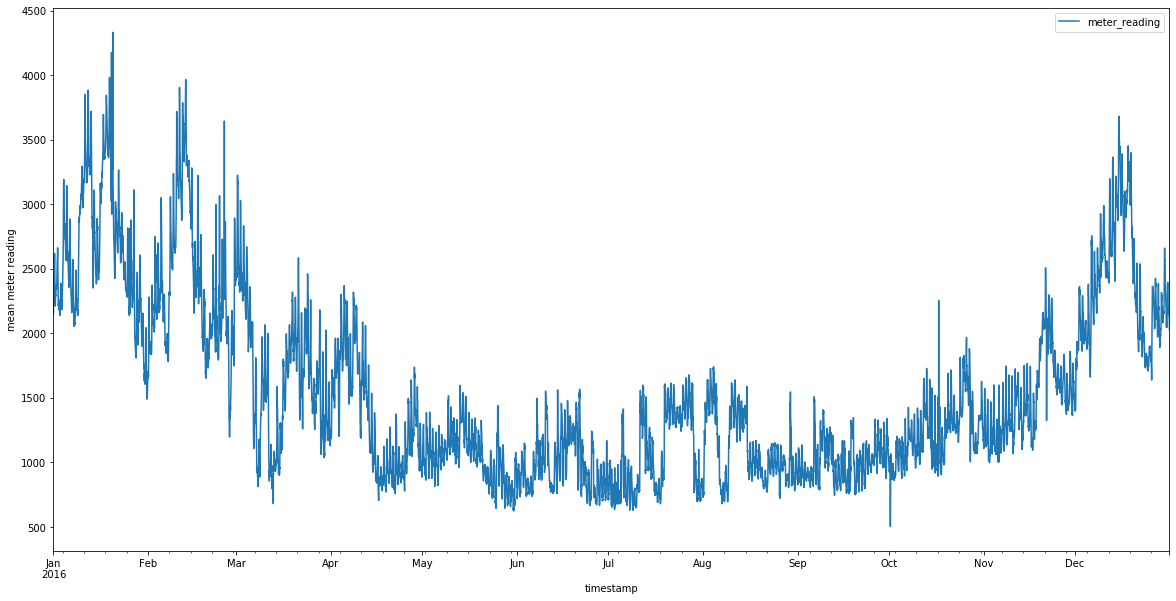

In [157]:
#plot the mean consumption of energy per month for the whole year to find patterns in data.
summaryTimestampOnly = train.groupby(["timestamp"]).agg("mean").reset_index()
summaryTimestampOnly.plot(x = "timestamp", y="meter_reading", figsize=(20,10))
plt.ylabel("mean meter reading")

### Generate the descriptive stats for each building

In [158]:
descriptiveStats = copy.deepcopy(train)
descriptiveStats.set_index(["building_id"], inplace=True)
descriptiveStats = descriptiveStats.groupby(descriptiveStats.index)["meter_reading"].agg(["min","max","mean","var"]).reset_index()
descriptiveStats.head(5)

,building_id,min,max,mean,var
0,745,0.0,599.925,109.350134,1.060974e+04
1,747,0.0,1222.290,128.029979,3.925886e+04
2,750,0.0,6371.570,3325.892579,1.257475e+06
3,751,0.0,768.232,187.881441,4.343621e+03
4,753,0.0,870.188,310.895075,4.900145e+03


In [159]:
#Adding a column for hour in the main dataframe to facilitate further analysis.
train["hour"] = train.index.hour
train.reset_index(inplace=True)
train.head(2)

,timestamp,building_id,meter,meter_reading,primary_use,hour
0,2016-01-01,745,2,0.000,Education,0
1,2016-01-01,747,2,120.786,Education,0


## Clustering over aggregate (mean) meter reading of each building for whole year for hour from 1 to 24

### Generate the pivot table using mean as the statistic

In [160]:
perHourElectricityConsumptionEachBuilding = train.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
perHourElectricityConsumptionEachBuilding.reset_index(inplace=True)
perHourElectricityConsumptionEachBuilding.head(5)

hour,building_id,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,745,33.822926,33.562455,36.934112,50.085926,44.252345,43.778380,50.619859,153.126593,156.354434,...,121.577887,121.651979,116.628250,123.299977,124.812050,122.973986,121.605441,123.634514,36.562442,29.301917
1,747,109.769685,108.580125,113.905629,113.252517,118.161253,119.248875,115.126350,197.199943,198.124581,...,131.293488,133.820216,138.924761,95.341798,89.300597,96.047924,102.408327,96.336393,112.017837,108.670704
2,750,3333.234754,3318.663907,3331.899507,3335.023716,3350.941913,3362.923497,3391.995956,3401.947432,3399.951325,...,3438.043568,3314.479374,3251.400462,3230.779781,3227.959071,3220.946284,3217.597014,3219.258497,3248.248607,3290.364317
3,751,182.841351,182.627967,182.429060,183.893000,182.058964,181.675699,181.279284,191.716651,198.279805,...,189.774659,188.580718,188.163879,187.166143,186.823486,186.233713,185.933011,184.458798,183.629555,183.438219
4,753,302.967399,301.988073,300.826707,302.528724,299.155557,296.616378,294.855492,294.227134,320.814082,...,320.265738,314.601249,313.379693,314.203144,307.814801,307.158041,304.412046,301.618191,303.733590,306.309869


### Generate the wcss vs cluster count and silhouette score vs cluster count plot

In [161]:
#setup for generating plot according to silhouette score for each number of clusters to extrcat the optimal number of clusters.
silhouette_scores = list()
inertia_list = list()
no_cluster = np.arange(2,30).astype(int) 

In [162]:
#scale the data for faster processing.
X = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuilding.values.copy())

In [163]:
#perform clustering with the required counts of clusters
for cluster in no_cluster:
    kmeans = KMeans(n_clusters=cluster, init="k-means++", n_init=10, n_jobs=-1,)
    c_f = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    inertia_list.append(kmeans.inertia_)

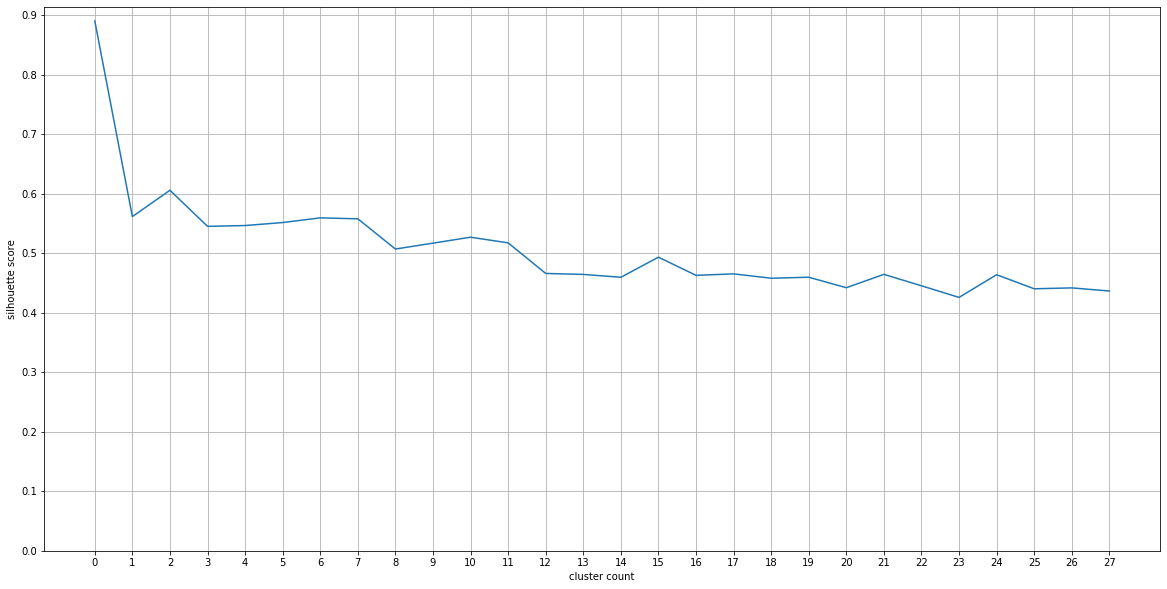

In [164]:
#plot the sihouette score vs cluster count graph.
plt.figure(figsize=(20,10))
plt.plot([i for i in range(0,28,1)], silhouette_scores)
plt.xticks([i for i in range(0,28,1)])
plt.yticks(np.arange(0,1,0.1))
plt.xlabel("cluster count")
plt.ylabel("silhouette score")
plt.grid()

### As silhouette score vs cluster count plot is not giving the desired result, we use elbow method to determine the best number of clusters

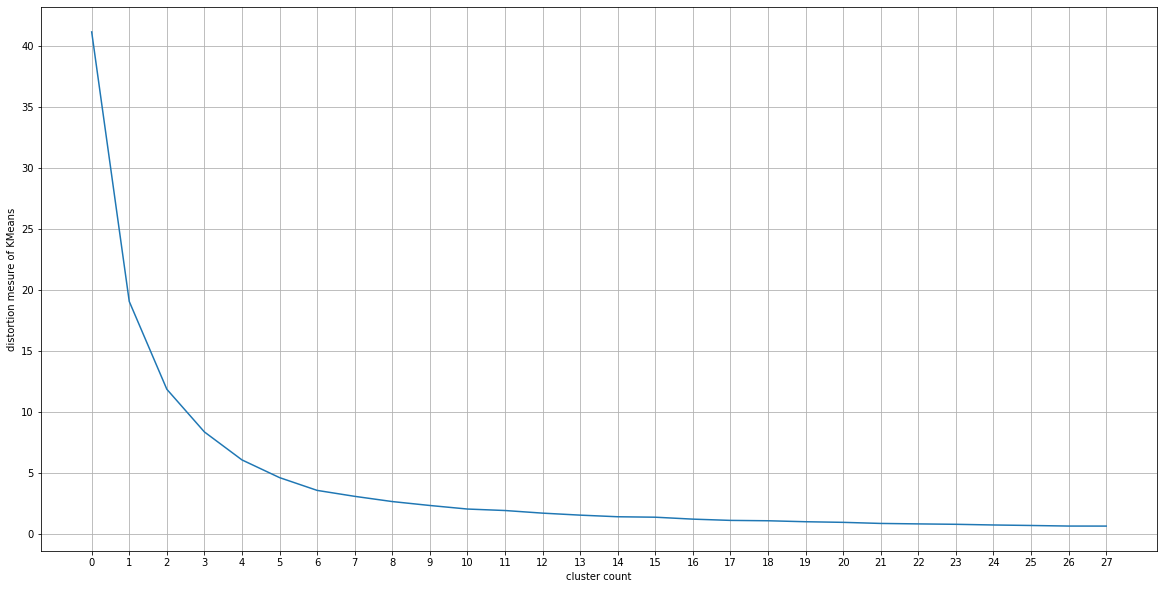

In [165]:
# plot the wcss vs cluster count graph
plt.figure(figsize=(20,10))
plt.plot([i for i in range(0,28,1)], inertia_list)
plt.xticks([i for i in range(0,28,1)])
plt.xlabel("cluster count")
plt.ylabel("distortion mesure of KMeans")
plt.grid()

### check the output of internal validation measure for cluster count = 2

In [166]:
kmeans = KMeans(n_clusters=2)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name="cluster")
perHourElectricityConsumptionEachBuilding.set_index("building_id", inplace=True)
perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr, append=True, inplace=True)
print("silhouette sample on euclidean metric: ",silhouette_samples(X, cluster_found))
print("silhouette score on euclidean metric: ",silhouette_score(X, cluster_found))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(X, cluster_found))
print("davis-B score on euclidean metric: ",davies_bouldin_score(X, cluster_found))

silhouette sample on euclidean metric:  [0.86161575 0.86228888 0.82981828 0.86358353 0.86412806 0.86450983
 0.86497823 0.8656972  0.86608805 0.86679109 0.84137193 0.86576959
 0.86817522 0.86800702 0.86913051 0.86943254 0.86974253 0.86976451
 0.87060771 0.87120531 0.87315394 0.82951957 0.87187615 0.87496902
 0.87498446 0.87452939 0.86044161 0.87691365 0.87503877 0.87514822
 0.87408019 0.87766256 0.87010003 0.87583941 0.87396043 0.89789371
 0.89811897 0.89836929 0.89882501 0.89914634 0.90017028 0.90057152
 0.90070599 0.90112121 0.90123494 0.90150125 0.90192269 0.90250788
 0.9025069  0.90289607 0.90323011 0.90360344 0.90364271 0.90416515
 0.90409595 0.90469691 0.90499129 0.9050894  0.90550629 0.90572528
 0.90626703 0.90601302 0.90663905 0.90680823 0.90684747 0.90685196
 0.90738758 0.90729486 0.90774947 0.90812825 0.90803267 0.908503
 0.90854179 0.90855976 0.90711008 0.90938628 0.90937064 0.90964003
 0.91005669 0.90968904 0.91018488 0.91149167 0.91203375 0.91211672
 0.91193577 0.91233813 0

### visualizing the clusters obtained by reducing the data to 2 dimensions using ISOMAP, t-SNE, UMAP

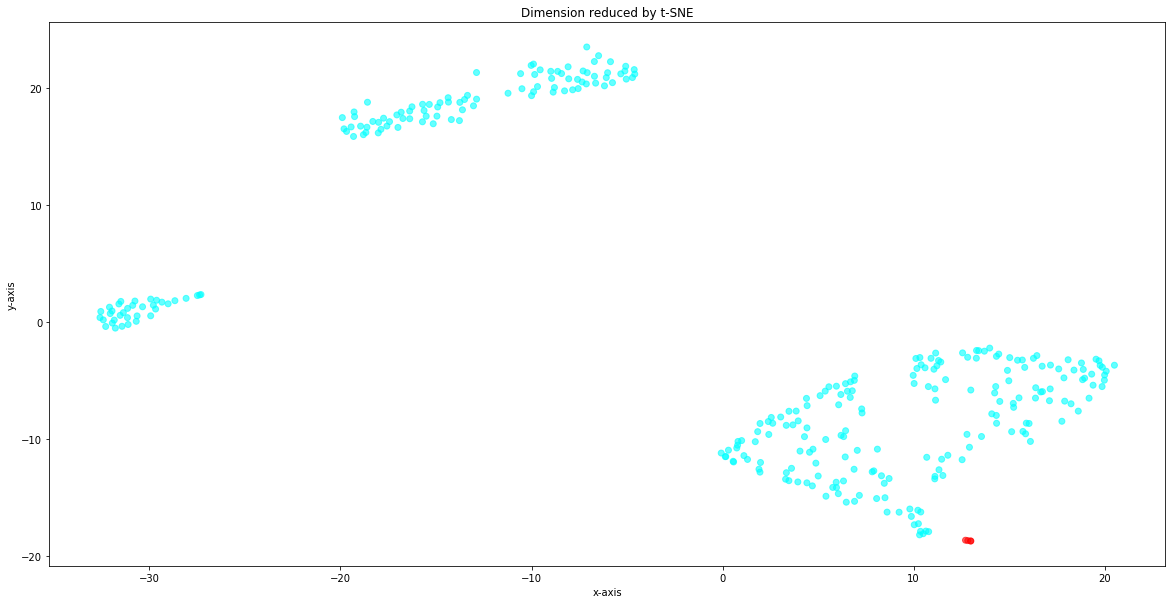

In [167]:
plot_tsne(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7)

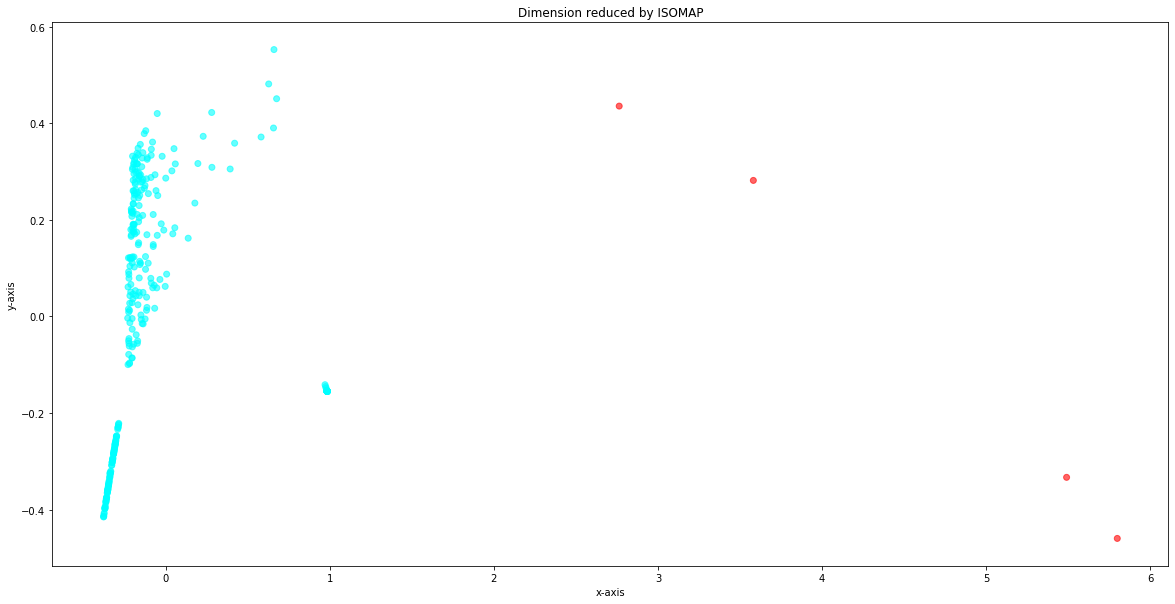

In [168]:
plot_isomap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


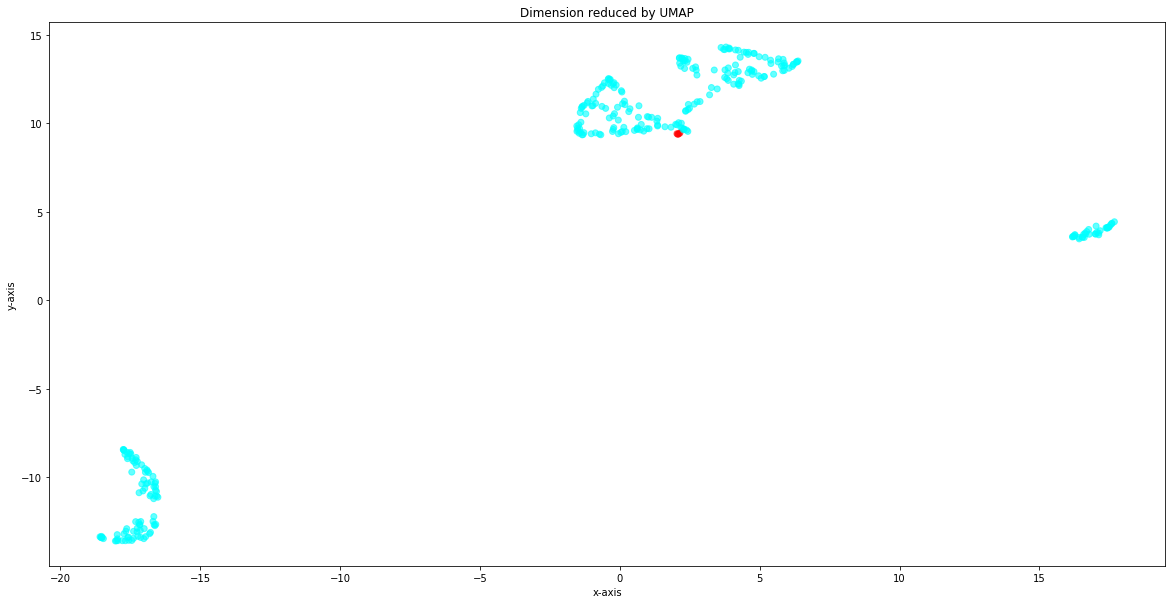

In [169]:
plot_umap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

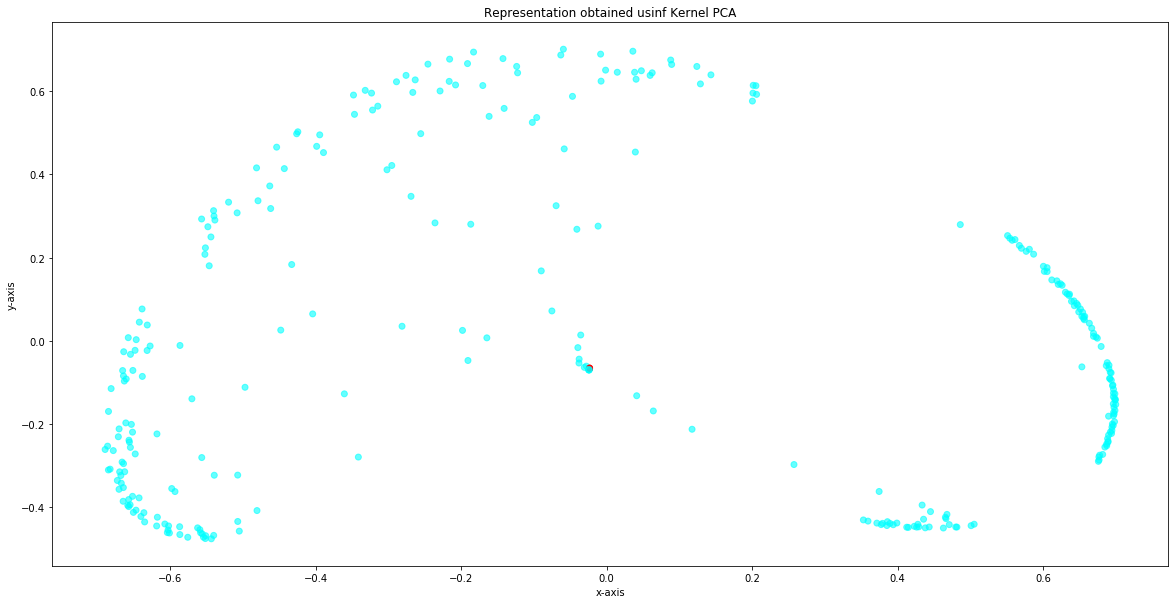

In [170]:
plot_kernel_pca(X, pivot=perHourElectricityConsumptionEachBuilding, kernel="rbf", g=15,rzev=True, deg = 1)

### As we see isomap gives the best representation of 2D for our data. In the subsequent sections we still will plot the points obtained via all 3 dimensionality reduction techniques but ISOMAP will be our emphasis.

### check the output of internal validation measure for cluster count = 3

In [171]:
perHourElectricityConsumptionEachBuilding.index = perHourElectricityConsumptionEachBuilding.index.droplevel(-1)
kmeans = KMeans(n_clusters=3)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name="cluster")
perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr, append=True, inplace=True)
print("silhouette sample on euclidean metric: ",silhouette_samples(X, cluster_found))
print("silhouette score on euclidean metric: ",silhouette_score(X, cluster_found))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(X, cluster_found))
print("davis-B score on euclidean metric: ",davies_bouldin_score(X, cluster_found))

silhouette sample on euclidean metric:  [ 6.97881563e-01  7.00631264e-01  4.95769239e-01  7.05529618e-01
  7.07394139e-01  7.08282858e-01  7.08611086e-01  7.11556055e-01
  7.13735144e-01  7.13895323e-01  5.37395223e-01  7.02292154e-01
  7.20741332e-01  7.17797134e-01  7.23369597e-01  7.24504192e-01
  7.25471493e-01  7.22917934e-01  7.28256397e-01  7.29567398e-01
  7.35141087e-01  4.47718381e-01  7.15556008e-01  7.40488377e-01
  7.38943114e-01  7.32787667e-01  6.14431928e-01  7.45235600e-01
  7.25699919e-01  7.24100909e-01  7.12710063e-01  7.44692506e-01
  6.73473688e-01  7.22875555e-01  7.03585831e-01  7.97065749e-01
  7.97551483e-01  7.96685127e-01  7.94690069e-01  8.00005947e-01
  8.01030551e-01  8.02756556e-01  8.02402816e-01  8.01382504e-01
  8.03549755e-01  7.99267554e-01  8.02719452e-01  8.05900088e-01
  8.04456799e-01  8.06020468e-01  8.05496063e-01  8.06396673e-01
  8.05473386e-01  8.06467010e-01  7.94405301e-01  8.05460490e-01
  8.06143108e-01  8.05091214e-01  8.06641388e-01  

### visualizing the clusters obtained by reducing the data to 2 dimensions using ISOMAP, t-SNE, UMAP

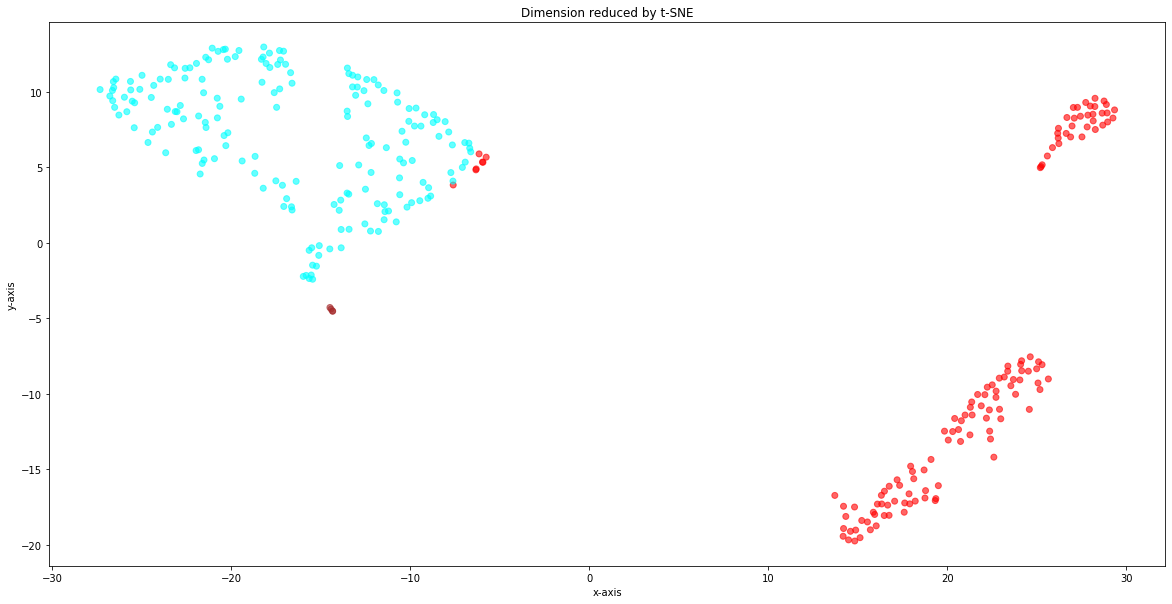

In [172]:
plot_tsne(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7)

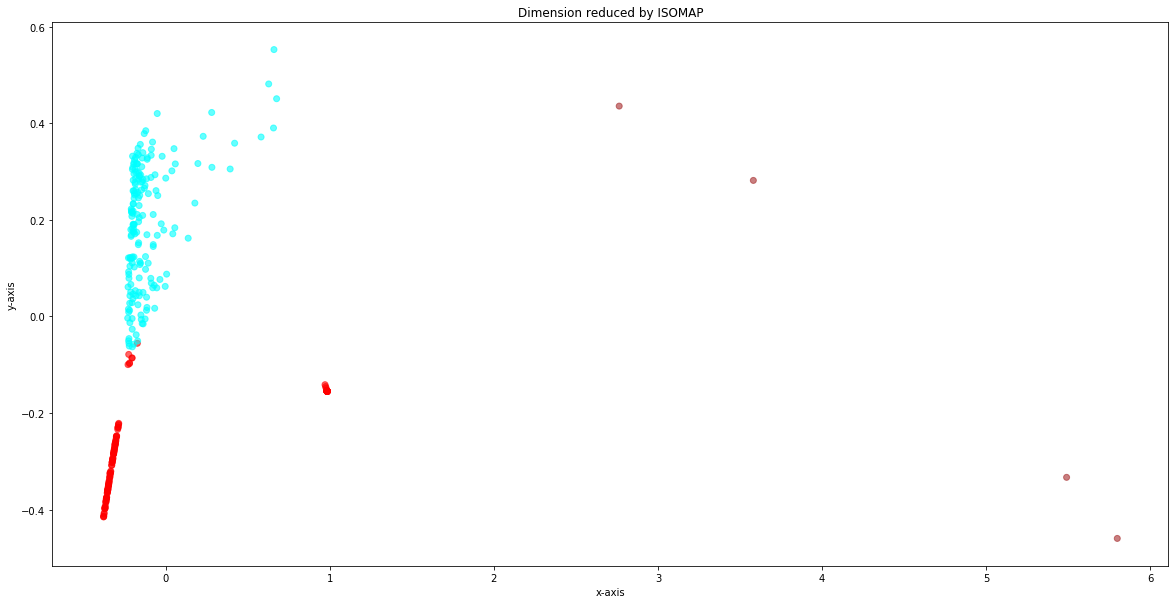

In [173]:
plot_isomap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


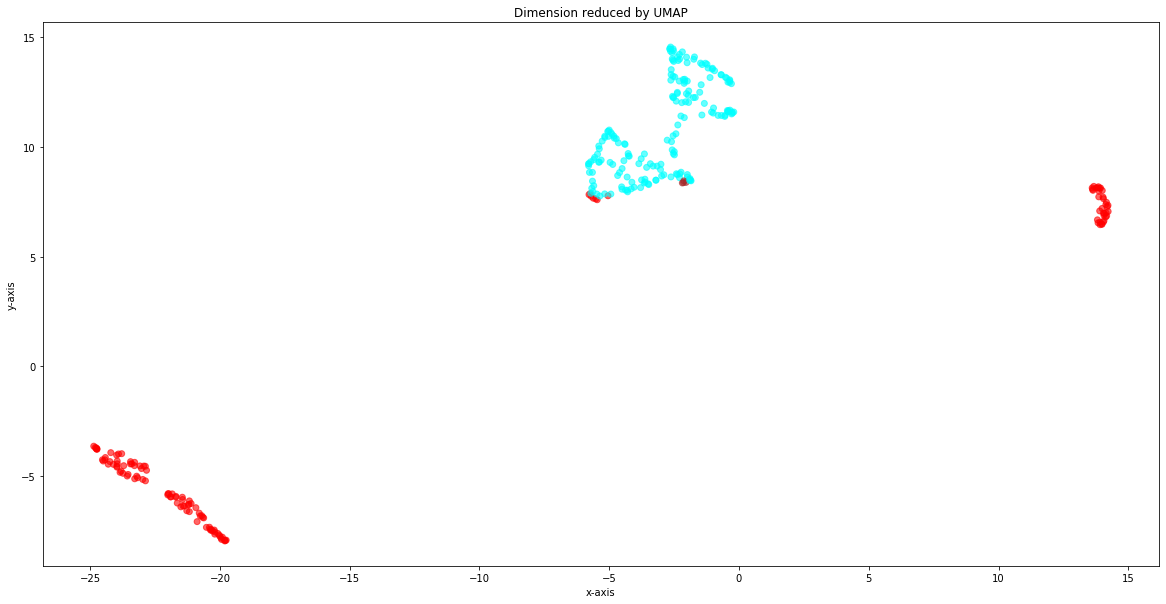

In [174]:
plot_umap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

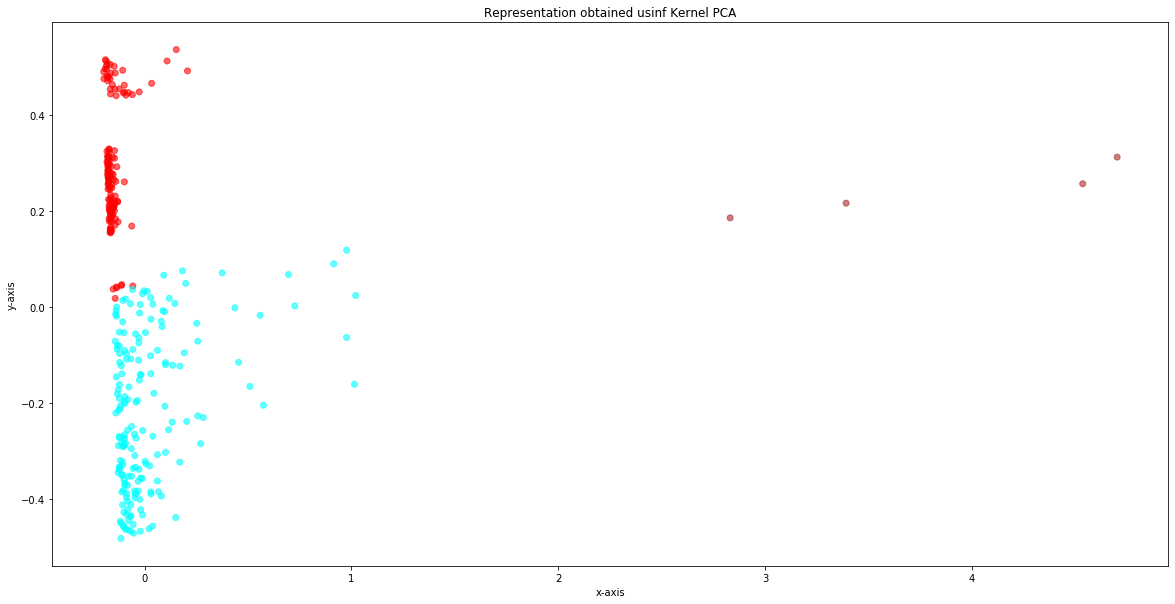

In [175]:
plot_kernel_pca(X, pivot=perHourElectricityConsumptionEachBuilding, kernel="linear", g=30,rzev=True, deg = 1)

### check the output of internal validation measure for cluster count = 4

In [176]:
perHourElectricityConsumptionEachBuilding.index = perHourElectricityConsumptionEachBuilding.index.droplevel(-1)
kmeans = KMeans(n_clusters=4)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name="cluster")
perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr, append=True, inplace=True)
print("silhouette sample on euclidean metric: ",silhouette_samples(X, cluster_found))
print("silhouette score on euclidean metric: ",silhouette_score(X, cluster_found))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(X, cluster_found))
print("davis-B score on euclidean metric: ",davies_bouldin_score(X, cluster_found))

silhouette sample on euclidean metric:  [ 0.69151564  0.69434972  0.49559937  0.69939819  0.70150218  0.70204704
  0.70297406  0.70516822  0.70753747  0.70732404  0.5354254   0.69701591
  0.71488244  0.71221743  0.71715997  0.718449    0.7193227   0.71631558
  0.7223036   0.72337709  0.72930745  0.44283171  0.71009809  0.73443538
  0.73319862  0.7272035   0.6099362   0.73912511  0.72016757  0.71841289
  0.70713912  0.73889955  0.66805889  0.71725135  0.69801924  0.78964416
  0.79008041  0.78891639  0.78737322  0.79248292  0.79318034  0.7950405
  0.79455146  0.79379396  0.79569025  0.7915999   0.79448898  0.79797833
  0.79626844  0.79794999  0.79722591  0.79822829  0.79707943  0.79834191
  0.78591885  0.79677541  0.79747871  0.79625782  0.79794652  0.79584884
  0.79703002  0.79407969  0.79421187  0.79646136  0.79531679  0.79305293
  0.79420237  0.79274158  0.79230889  0.78866443  0.79028951  0.78187148
  0.78779279  0.78541986  0.74094195  0.78612874  0.78550851  0.78305748
  0.78268626

### visualizing the clusters obtained by reducing the data to 2 dimensions using ISOMAP, t-SNE, UMAP

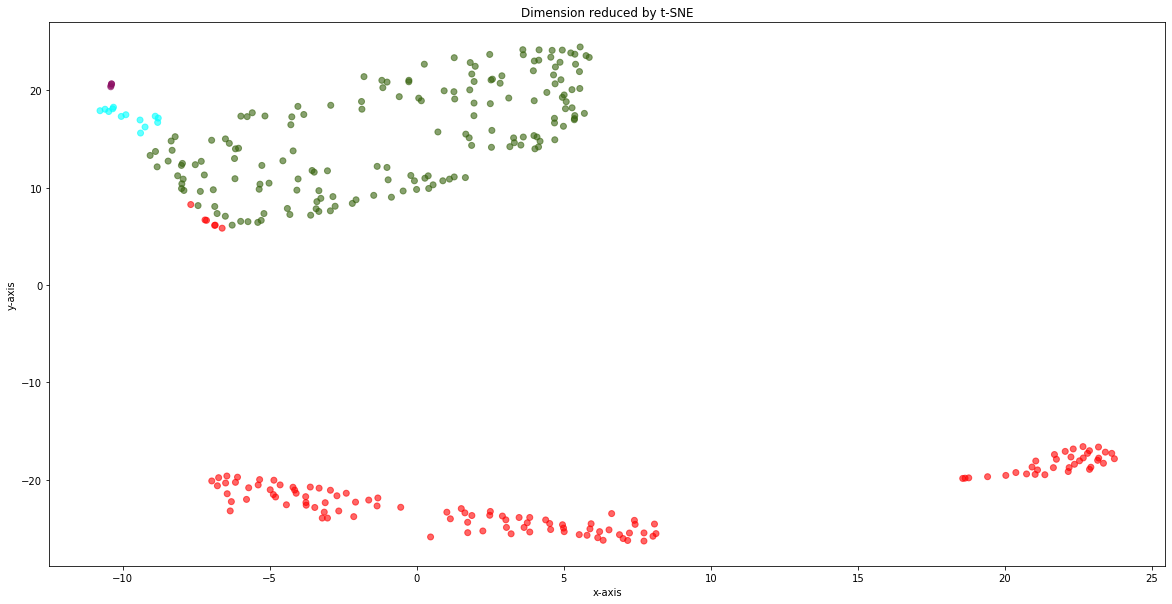

In [177]:
plot_tsne(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7)

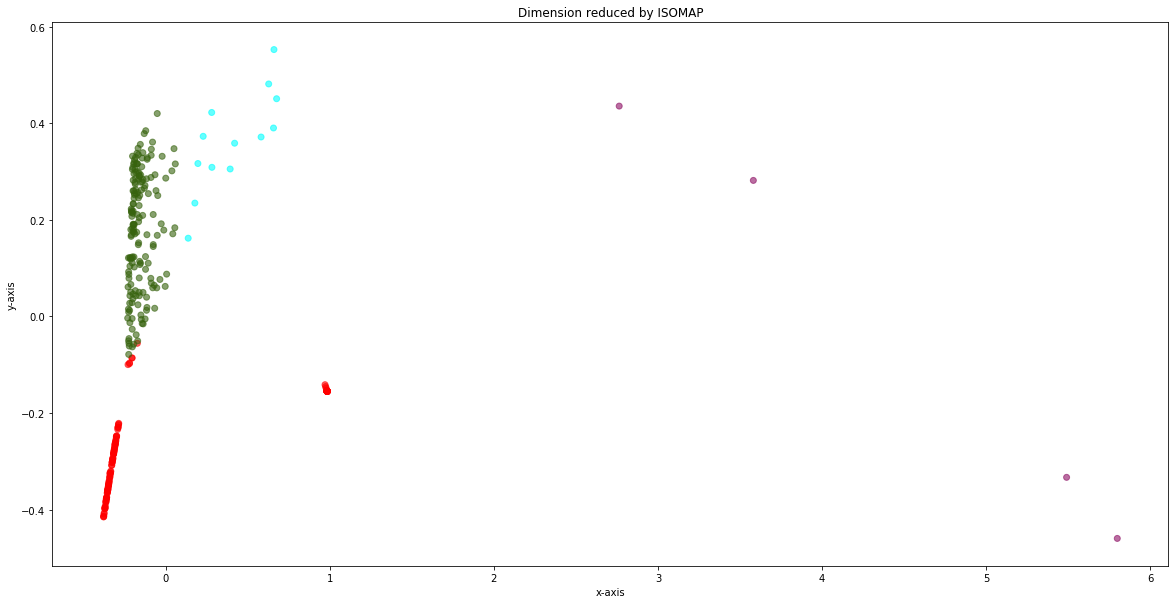

In [178]:
plot_isomap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


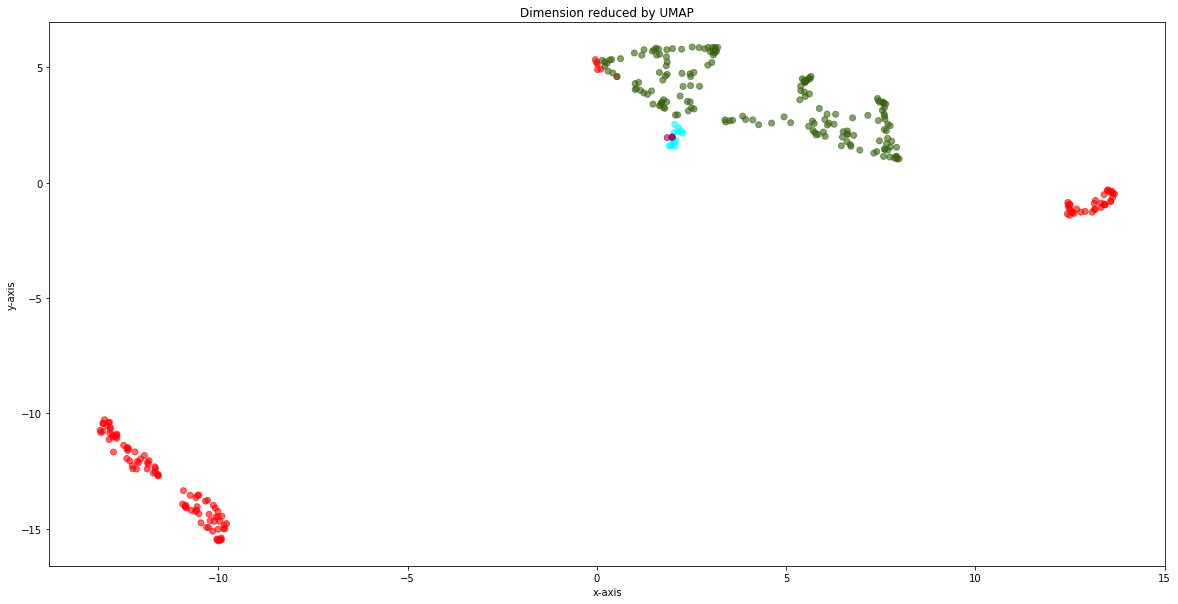

In [179]:
plot_umap(X, pivot=perHourElectricityConsumptionEachBuilding, alpha=0.7, neighbor=20, dimension=2)

### We see that even increasing the cluster count does not improve the internal validation score of our clusters. Hence, we shall be dividing the data into quarters and experimenting with the same technique once again. 

### Some other observations

### Associate each building with its primary use

In [180]:
#map corresponding building to its primary use
temp = train.drop_duplicates(["building_id","primary_use"])
temp = temp[["building_id", "primary_use"]]
temp.set_index("building_id")
temp.sort_values(by="building_id", inplace=True) 

### Get a count of total number of each category in primary use

In [181]:
#make a copy oforiginalpivot_table
temp2 = copy.deepcopy(perHourElectricityConsumptionEachBuilding)
perHourElectricityConsumptionEachBuilding.reset_index(level = ["building_id","cluster"], inplace=True)
perHourElectricityConsumptionEachBuilding = pd.merge(perHourElectricityConsumptionEachBuilding,temp, left_on="building_id", right_on="building_id", how="left")
perHourElectricityConsumptionEachBuilding.set_index(["building_id","cluster"], inplace=True)
perHourElectricityConsumptionEachBuilding.groupby([perHourElectricityConsumptionEachBuilding.index.get_level_values("cluster"),"primary_use"])["primary_use"].agg("count")
perHourElectricityConsumptionEachBuilding

,,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,primary_use
building_id,cluster,,,,,,,,,,,,,,,,,,,,,
745,0,33.822926,33.562455,36.934112,50.085926,44.252345,43.778380,50.619859,153.126593,156.354434,157.216085,...,121.651979,116.628250,123.299977,124.812050,122.973986,121.605441,123.634514,36.562442,29.301917,Education
747,0,109.769685,108.580125,113.905629,113.252517,118.161253,119.248875,115.126350,197.199943,198.124581,179.652764,...,133.820216,138.924761,95.341798,89.300597,96.047924,102.408327,96.336393,112.017837,108.670704,Education
750,0,3333.234754,3318.663907,3331.899507,3335.023716,3350.941913,3362.923497,3391.995956,3401.947432,3399.951325,3428.938238,...,3314.479374,3251.400462,3230.779781,3227.959071,3220.946284,3217.597014,3219.258497,3248.248607,3290.364317,Education
751,0,182.841351,182.627967,182.429060,183.893000,182.058964,181.675699,181.279284,191.716651,198.279805,199.458263,...,188.580718,188.163879,187.166143,186.823486,186.233713,185.933011,184.458798,183.629555,183.438219,Office
753,0,302.967399,301.988073,300.826707,302.528724,299.155557,296.616378,294.855492,294.227134,320.814082,338.747426,...,314.601249,313.379693,314.203144,307.814801,307.158041,304.412046,301.618191,303.733590,306.309869,Education
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,1,422.081474,433.965917,445.050735,456.512347,458.205053,489.290299,609.175404,667.217828,645.974536,579.616800,...,441.481261,414.446126,401.948173,425.734214,434.687697,420.898081,422.459539,431.472426,425.813939,Education
1436,1,1101.500337,846.419139,803.488869,793.733003,779.549833,798.531318,1068.787580,1815.096743,1948.235019,1731.340032,...,1467.993741,1368.511658,1322.532064,1313.195958,1345.466952,1398.257260,1423.269215,1439.922878,1278.197439,Manufacturing/industrial
1437,1,917.829212,922.168276,921.210513,933.000641,961.699087,1011.715090,1056.343875,1089.734550,1085.587515,1016.511330,...,810.316248,802.089566,825.843010,845.514635,857.235932,890.286617,906.146878,895.609026,892.318346,Education


### assign a numeric value to each categpry in primary use for further use in later sections

In [182]:
perHourElectricityConsumptionEachBuilding["code"] = perHourElectricityConsumptionEachBuilding["primary_use"].astype("category").cat.codes
perHourElectricityConsumptionEachBuilding

,,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,primary_use,code
building_id,cluster,,,,,,,,,,,,,,,,,,,,,
745,0,33.822926,33.562455,36.934112,50.085926,44.252345,43.778380,50.619859,153.126593,156.354434,157.216085,...,116.628250,123.299977,124.812050,122.973986,121.605441,123.634514,36.562442,29.301917,Education,0
747,0,109.769685,108.580125,113.905629,113.252517,118.161253,119.248875,115.126350,197.199943,198.124581,179.652764,...,138.924761,95.341798,89.300597,96.047924,102.408327,96.336393,112.017837,108.670704,Education,0
750,0,3333.234754,3318.663907,3331.899507,3335.023716,3350.941913,3362.923497,3391.995956,3401.947432,3399.951325,3428.938238,...,3251.400462,3230.779781,3227.959071,3220.946284,3217.597014,3219.258497,3248.248607,3290.364317,Education,0
751,0,182.841351,182.627967,182.429060,183.893000,182.058964,181.675699,181.279284,191.716651,198.279805,199.458263,...,188.163879,187.166143,186.823486,186.233713,185.933011,184.458798,183.629555,183.438219,Office,6
753,0,302.967399,301.988073,300.826707,302.528724,299.155557,296.616378,294.855492,294.227134,320.814082,338.747426,...,313.379693,314.203144,307.814801,307.158041,304.412046,301.618191,303.733590,306.309869,Education,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,1,422.081474,433.965917,445.050735,456.512347,458.205053,489.290299,609.175404,667.217828,645.974536,579.616800,...,414.446126,401.948173,425.734214,434.687697,420.898081,422.459539,431.472426,425.813939,Education,0
1436,1,1101.500337,846.419139,803.488869,793.733003,779.549833,798.531318,1068.787580,1815.096743,1948.235019,1731.340032,...,1368.511658,1322.532064,1313.195958,1345.466952,1398.257260,1423.269215,1439.922878,1278.197439,Manufacturing/industrial,5
1437,1,917.829212,922.168276,921.210513,933.000641,961.699087,1011.715090,1056.343875,1089.734550,1085.587515,1016.511330,...,802.089566,825.843010,845.514635,857.235932,890.286617,906.146878,895.609026,892.318346,Education,0


# Divide data into quarters and perform the above experiment.

#### Experiment over quarter 1

In [183]:
quarter1 = copy.deepcopy(train)
quarter1["quarter"] = quarter1["timestamp"].dt.quarter
quarter1 = quarter1[quarter1["quarter"]==1]
quarter1["meter_reading"].fillna(0, inplace=True)

In [184]:
perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
#perHourElectricityConsumptionEachBuildingQ1.drop(perHourElectricityConsumptionEachBuildingQ1.index[[1100,779,1198,1089,1022,1169,1160,1149,1285]], inplace=True)
perHourElectricityConsumptionEachBuildingQ1.head(5)

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
building_id,,,,,,,,,,,,,,,,,,,,,
745,10.645414,11.308243,12.601478,28.327356,18.091427,17.473429,22.236720,199.817978,231.428001,223.147112,...,151.167005,157.136783,159.138193,159.444087,162.392636,161.413012,168.761837,167.773926,32.340286,8.791755
747,235.543596,244.894470,244.907003,249.171163,254.337734,249.329254,260.294715,435.691409,447.320040,409.036812,...,306.730962,313.908195,317.614658,232.614767,227.269146,235.350698,242.543705,221.121059,245.297052,230.394741
750,4062.343407,4028.770000,4038.570556,4047.462308,4059.790989,4132.216044,4206.221319,4280.431538,4255.057033,4170.195714,...,4020.310769,3832.281648,3764.331099,3757.566044,3795.126703,3868.837802,3865.923703,3905.261099,3957.211978,4025.766374
751,127.673055,127.661824,126.812711,133.863077,127.627077,127.673451,127.449857,146.862209,162.972622,165.505000,...,147.140725,144.462846,142.838791,139.819516,138.402538,137.404714,137.267747,133.225242,130.663341,130.126132
753,334.833110,329.633865,324.994121,328.451164,318.421296,312.380769,313.917275,316.266319,349.977231,388.162923,...,344.743231,332.884890,328.663132,325.605758,319.516286,321.283165,325.331516,322.810484,331.684066,334.915286


In [185]:
XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuildingQ1.values.copy())
XQ1

array([[0.00016591, 0.00017453, 0.00019219, ..., 0.00273058, 0.00052107,
        0.0001396 ],
       [0.00367104, 0.00377975, 0.0037352 , ..., 0.00359882, 0.00395227,
        0.00365825],
       [0.06331322, 0.06218082, 0.06159426, ..., 0.06355943, 0.06375924,
        0.06392178],
       ...,
       [0.03020957, 0.02997171, 0.02983402, ..., 0.03070619, 0.03006618,
        0.02968813],
       [0.01873493, 0.01849515, 0.01818946, ..., 0.01839139, 0.01858882,
        0.01837927],
       [0.00105517, 0.00104349, 0.00101885, ..., 0.00108544, 0.00099959,
        0.00104744]])

In [186]:
silhouette_scores_q1 = list()
inertia = list()
no_cluster = np.arange(2,28).astype("int")
for cluster in no_cluster:
    kmeansQ1 = KMeans(n_clusters=cluster, init="k-means++")
    c_f = kmeansQ1.fit_predict(XQ1)
    silhouette_scores_q1.append(silhouette_score(XQ1, kmeansQ1.labels_))
    inertia.append(kmeansQ1.inertia_)
    

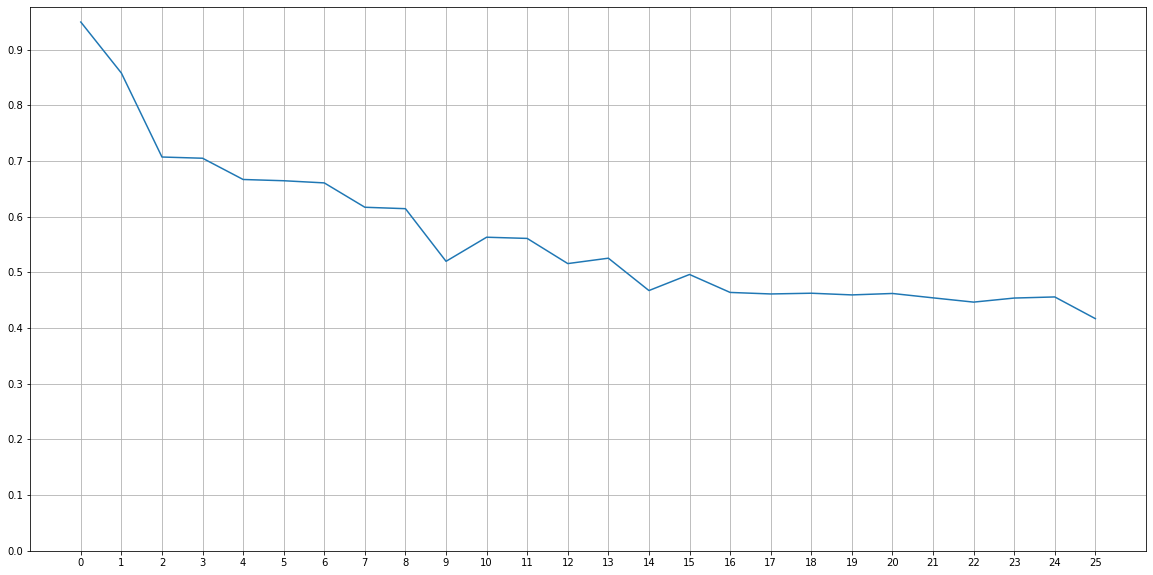

In [187]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(0,26,1)], silhouette_scores_q1)
plt.xticks([i for i in range(0,26,1)])
plt.yticks(np.arange(0,1,0.1))
plt.grid()

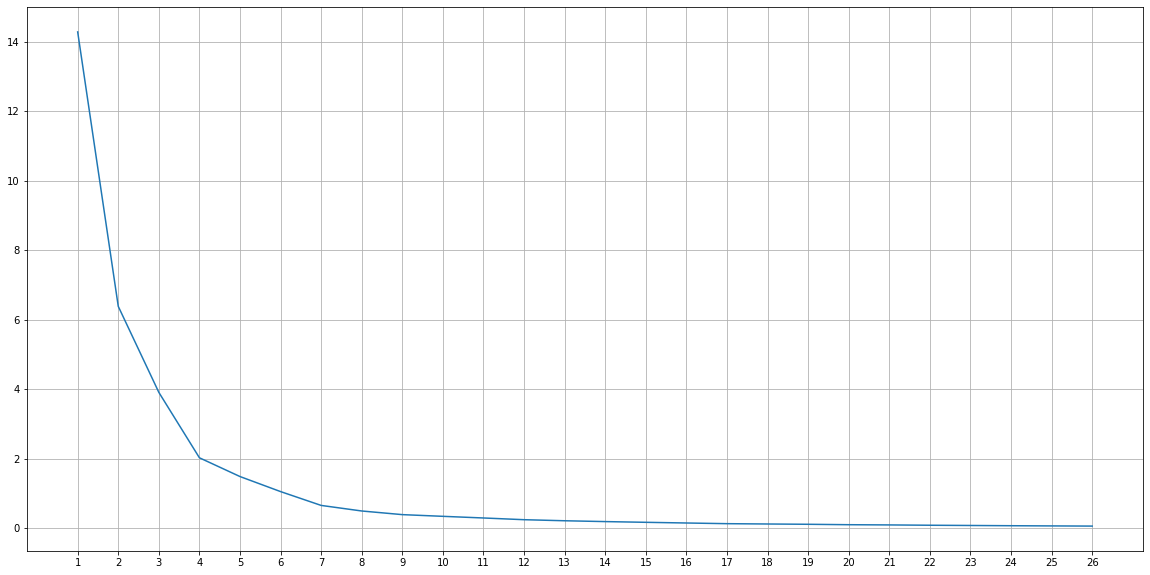

In [188]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(1,27,1)], inertia)
plt.xticks([i for i in range(1,27,1)])
plt.grid()

#### Clustering with euclidean distance

In [189]:
kmeans = KMeans(n_clusters=3)
cluster_found_q1 = kmeans.fit_predict(XQ1)
cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)

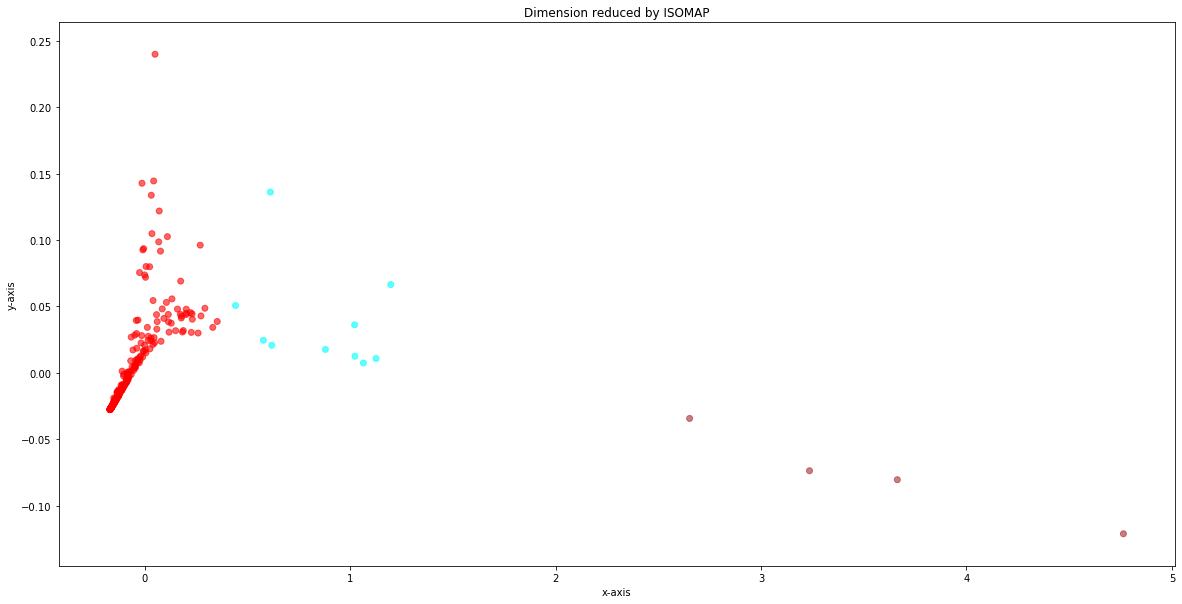

In [190]:
plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor=10)

#### Clustering with DTW distance

In [191]:
perHourElectricityConsumptionEachBuildingQ1.index = perHourElectricityConsumptionEachBuildingQ1.index.droplevel(-1)
kmeansTslearn = TimeSeriesKMeans(n_clusters=3, max_iter=1000, metric="dtw", n_jobs=4, init="k-means++")
cluster_found_q1 = kmeansTslearn.fit_predict(XQ1)
cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
perHourElectricityConsumptionEachBuildingQ1.set_index(cluster_found_sr_q1, append=True, inplace=True)

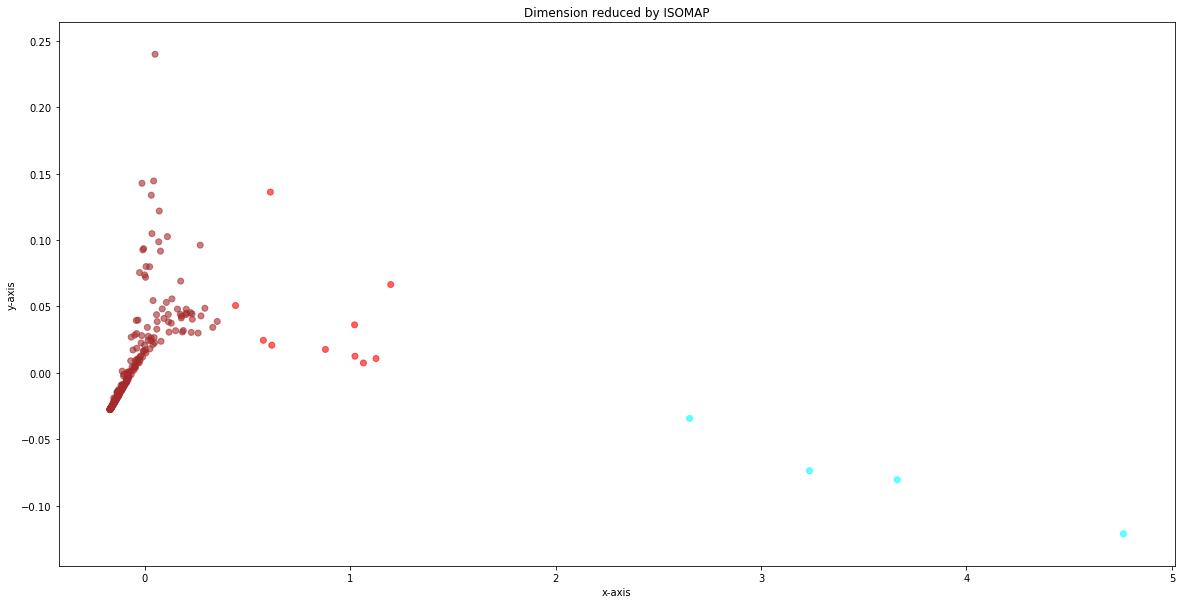

In [192]:
plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingQ1, dimension=2, neighbor = 10)

In [193]:
# printing the score of internal validation measures
print("silhouette score on euclidean metric: ",silhouette_score(XQ1, kmeans.labels_))
print("silhouette score on dtw metric: ",silhouette_score(XQ1, kmeansTslearn.labels_))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, kmeans.labels_))
print("calsinki-H score on dtw metric: ",calinski_harabasz_score(XQ1, kmeansTslearn.labels_))
print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, kmeans.labels_))
print("davis-B score on dtw metric: ",davies_bouldin_score(XQ1, kmeansTslearn.labels_))

silhouette score on euclidean metric:  0.8579298892635384
silhouette score on dtw metric:  0.8579298892635384
calsinki-H score on euclidean metric:  1412.3009555386784
calsinki-H score on dtw metric:  1412.3009555386782
davis-B score on euclidean metric:  0.3542521184054679
davis-B score on dtw metric:  0.35425211840546794


## Perform Kmeans on quarter 2 with distances: euclidean, DTW

Internal Validation scores for quarter 2
silhouette score on euclidean metric:  0.8502574182759224
silhouette score on dtw metric:  0.8502574182759224
calsinki-H score on euclidean metric:  1261.2078078044235
calsinki-H score on dtw metric:  1261.2078078044233
davis-B score on euclidean metric:  0.5165762083461495
davis-B score on dtw metric:  0.5165762083461495


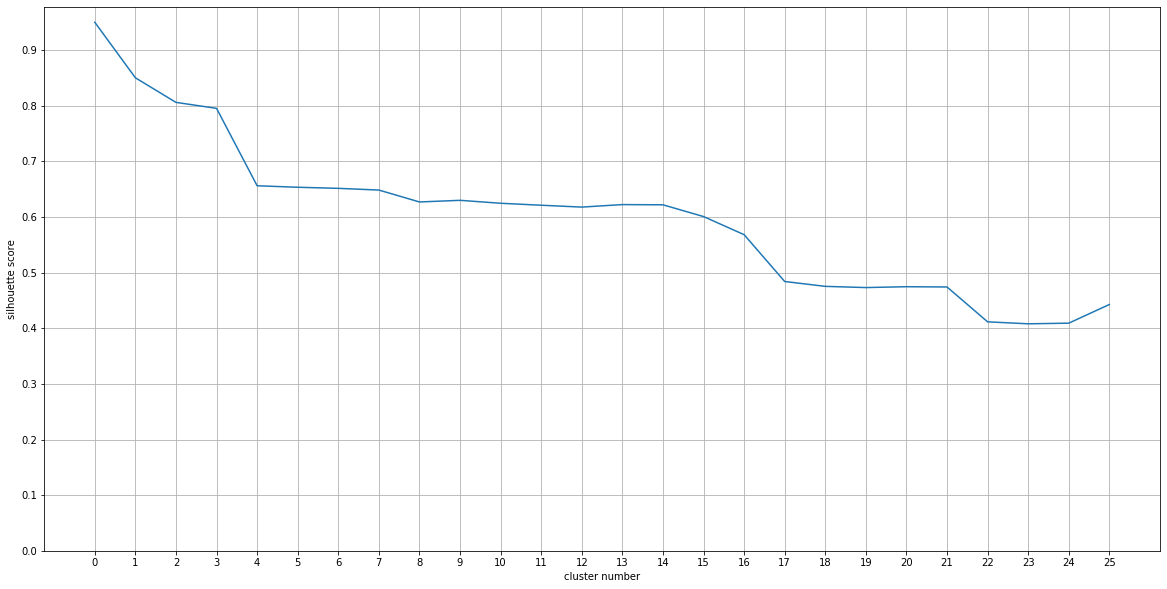

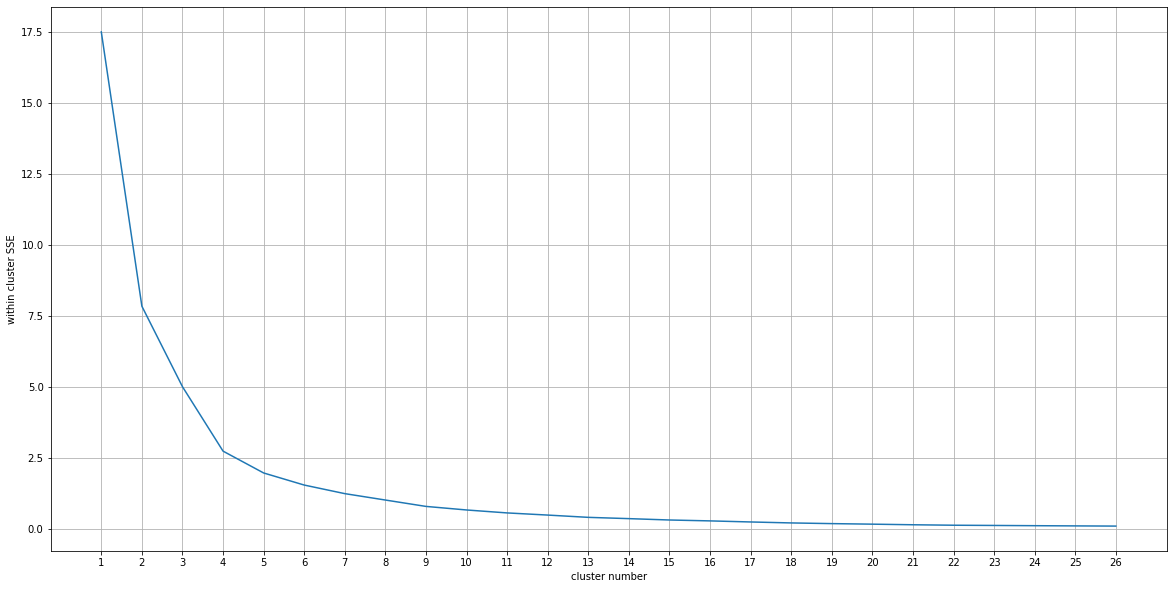

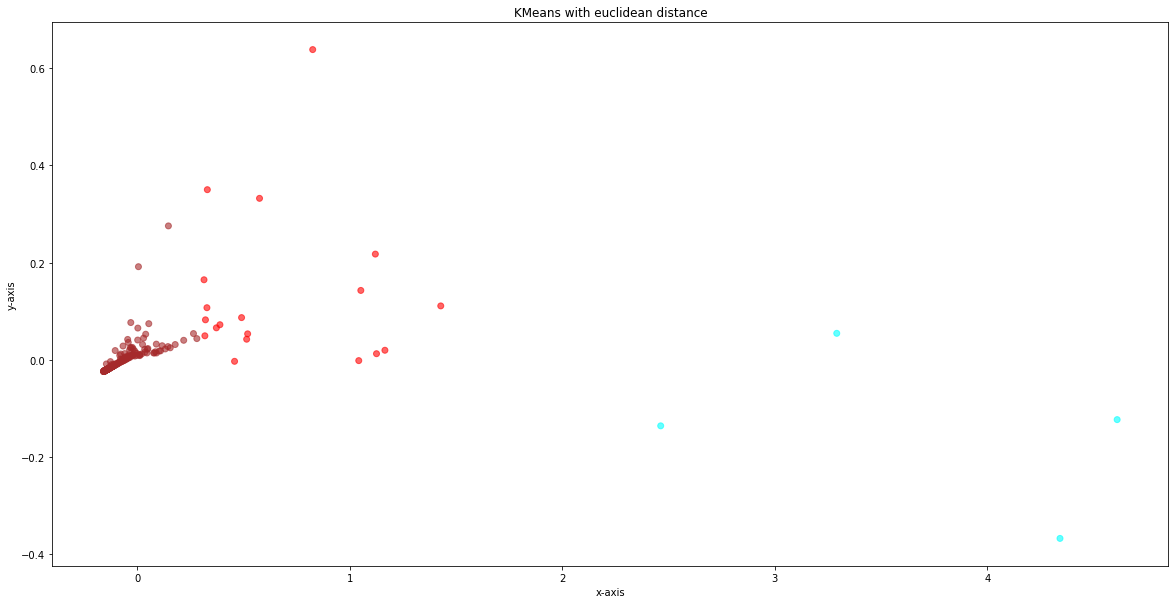

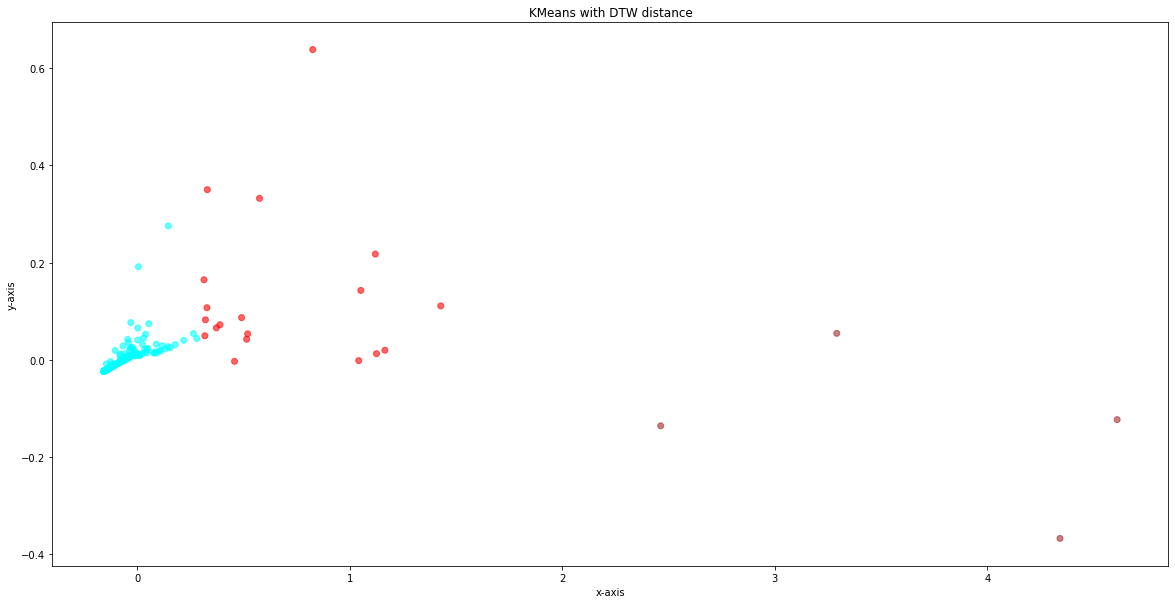

In [194]:
perform_clustering_quarter_wise(2, train)

## Perform Kmeans on quarter 3 with distances: euclidean, DTW

Internal Validation scores for quarter 3
silhouette score on euclidean metric:  0.9013762742180687
silhouette score on dtw metric:  0.8945879019204055
calsinki-H score on euclidean metric:  1865.6883915513515
calsinki-H score on dtw metric:  1858.4160405738533
davis-B score on euclidean metric:  0.3775341234342311
davis-B score on dtw metric:  0.41872378820262207


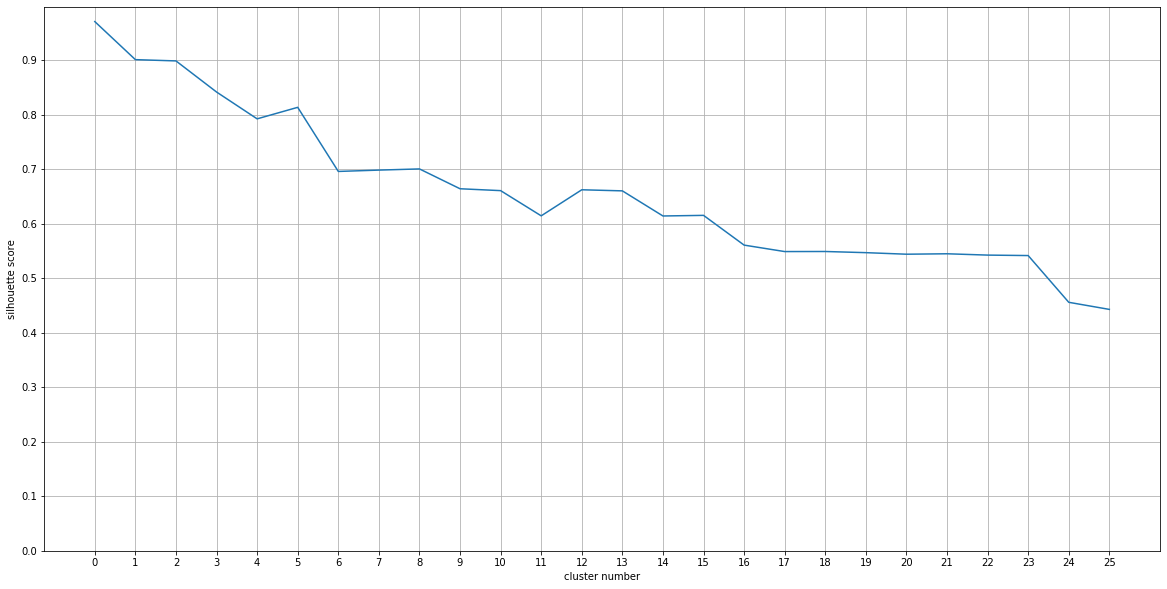

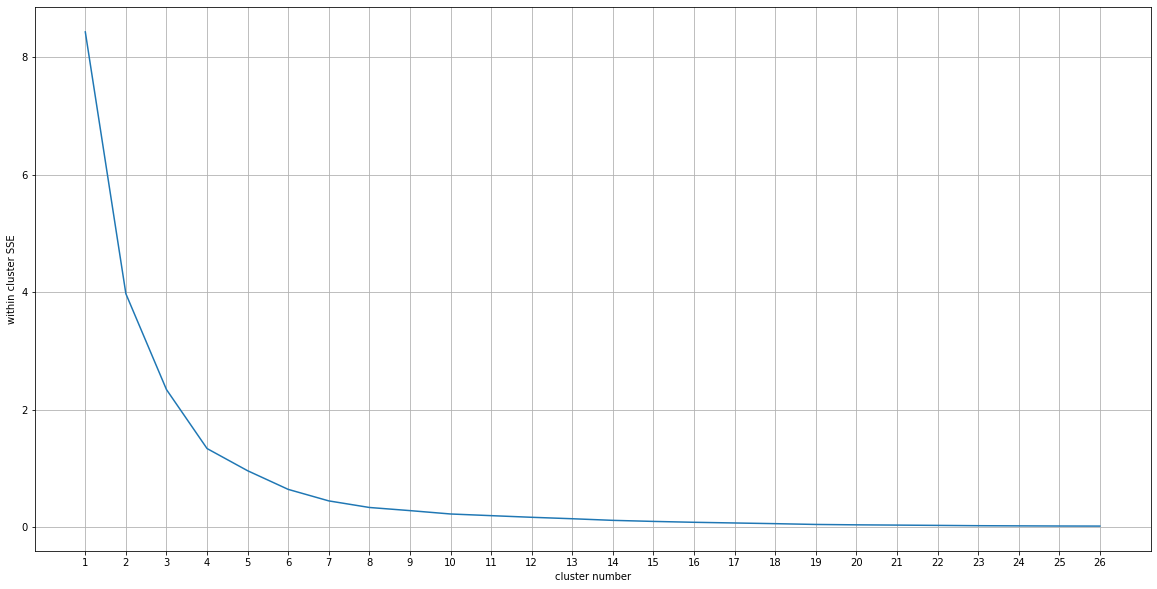

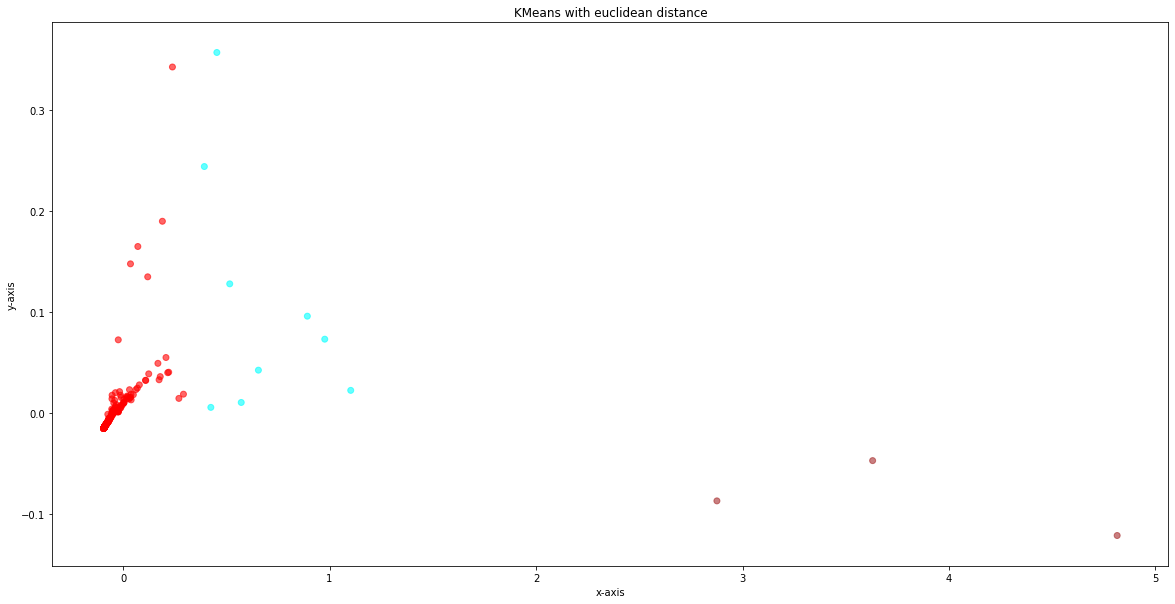

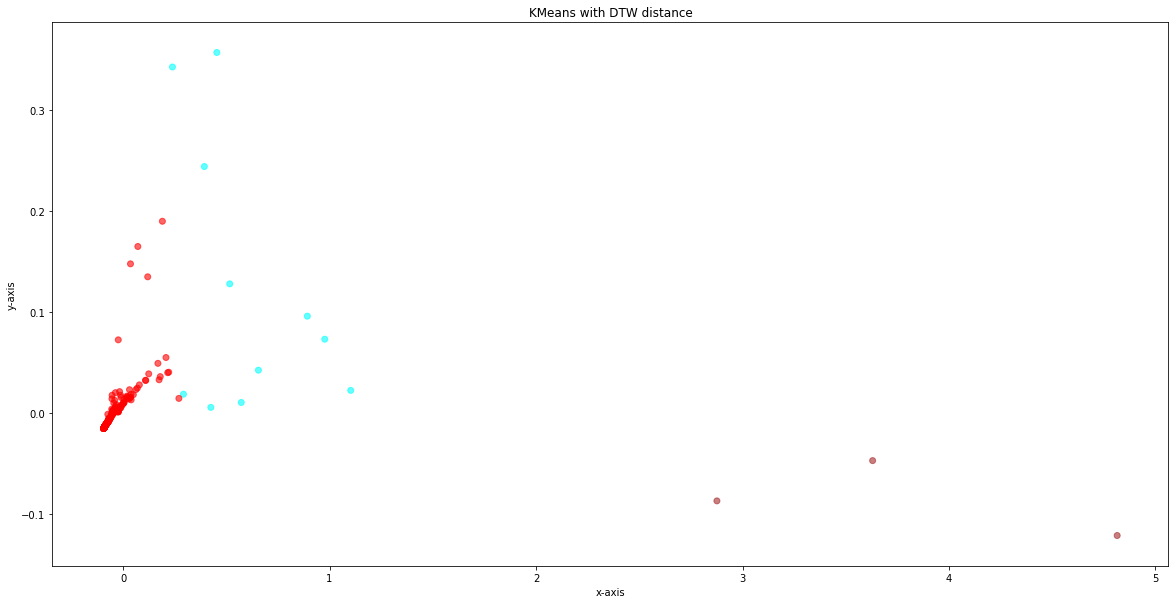

In [195]:
perform_clustering_quarter_wise(3, train)

## Perform Kmeans on quarter 4 with distances: euclidean, DTW

Internal Validation scores for quarter 4
silhouette score on euclidean metric:  0.834888369237893
silhouette score on dtw metric:  0.834888369237893
calsinki-H score on euclidean metric:  1624.8282288734474
calsinki-H score on dtw metric:  1624.8282288734474
davis-B score on euclidean metric:  0.4009085328929239
davis-B score on dtw metric:  0.4009085328929239


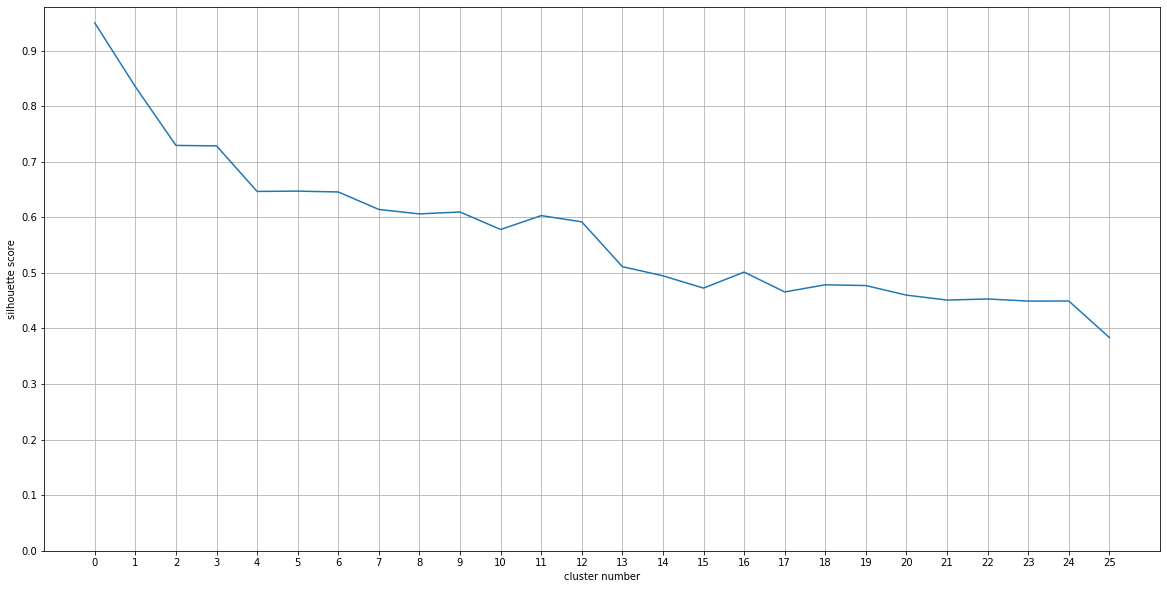

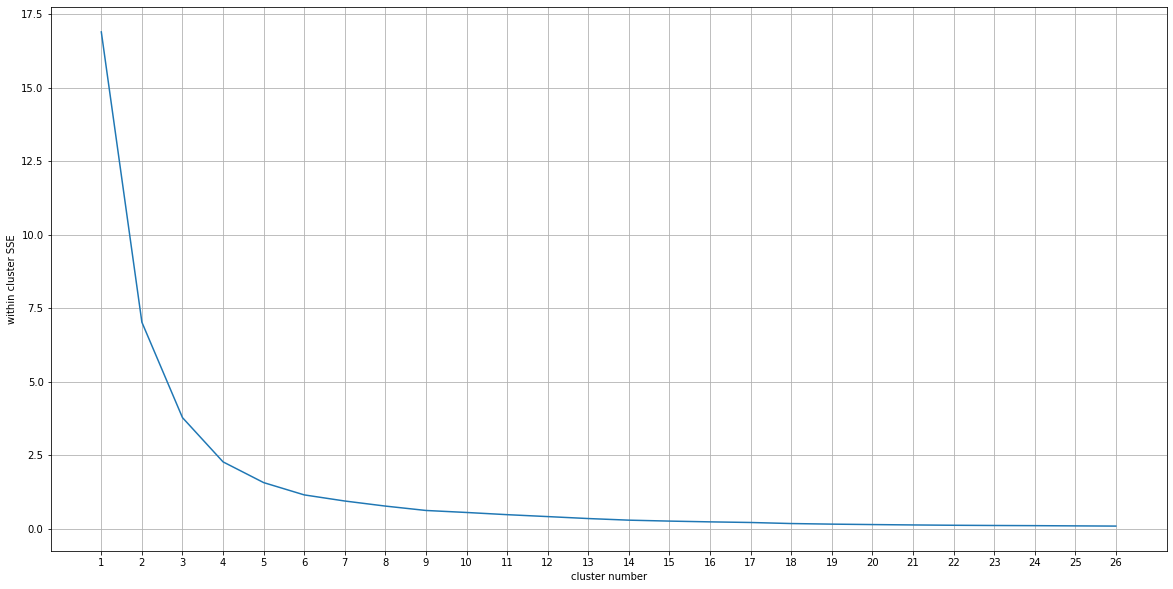

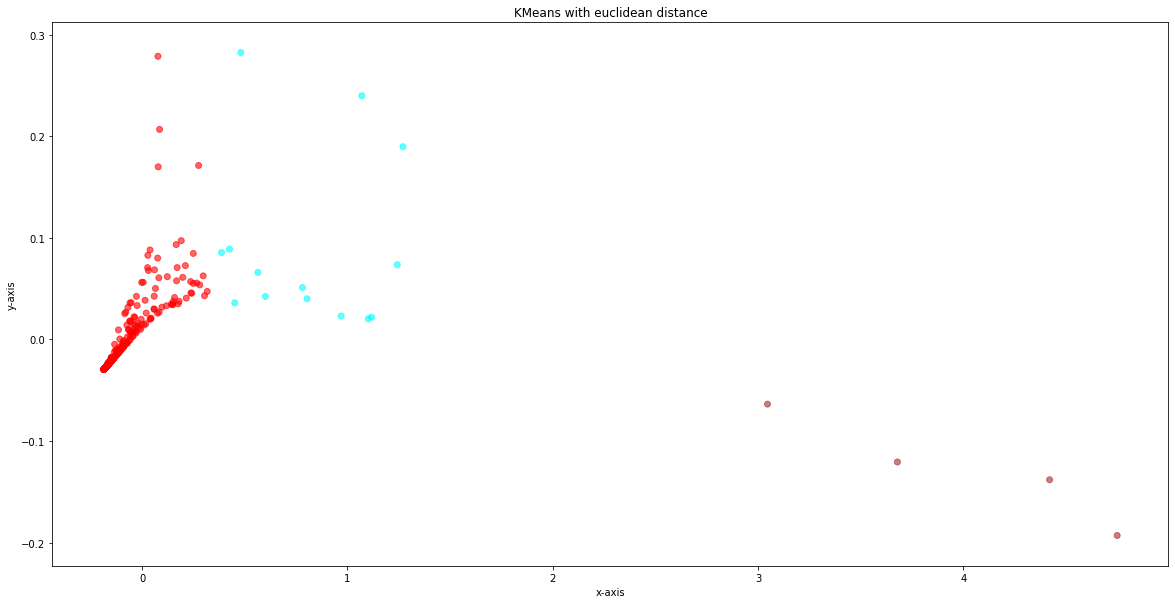

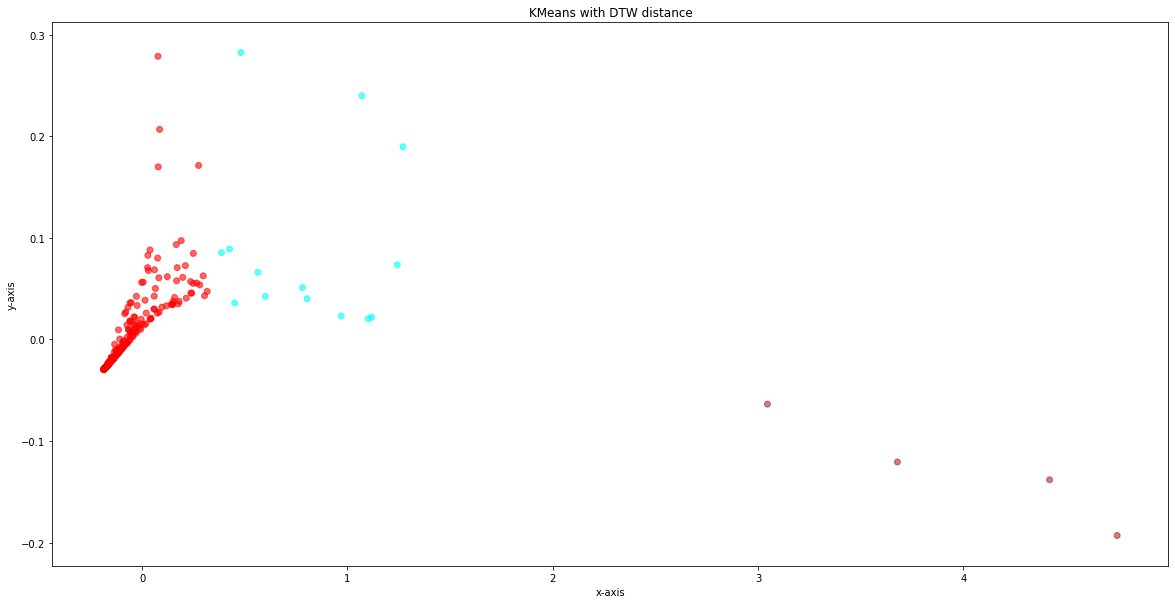

In [196]:
perform_clustering_quarter_wise(4, train)

## Outcome: KMeans with DTW distance does perform better than euclidean distance i.e. Measures based on editing of the time series performed better than shape based distance in the above case. 

# Experiment with spectral clustering..
### 1. First with whole year aggregate data
### 2. Then with quarterly data if the score is not according to the requirement.

In [197]:
wholeYear = copy.deepcopy(train)
perHourElectricityConsumptionEachBuildingWholeYear = wholeYear.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuildingWholeYear.values.copy())

spectralCluster = SpectralClustering(n_clusters=2, n_init=10, assign_labels="discretize", n_jobs=-1, random_state=0, degree=3, affinity="nearest_neighbors")
cluster_found_q1 = spectralCluster.fit_predict(XQ1)
cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
perHourElectricityConsumptionEachBuildingWholeYear.set_index(cluster_found_sr_q1, append=True, inplace=True)

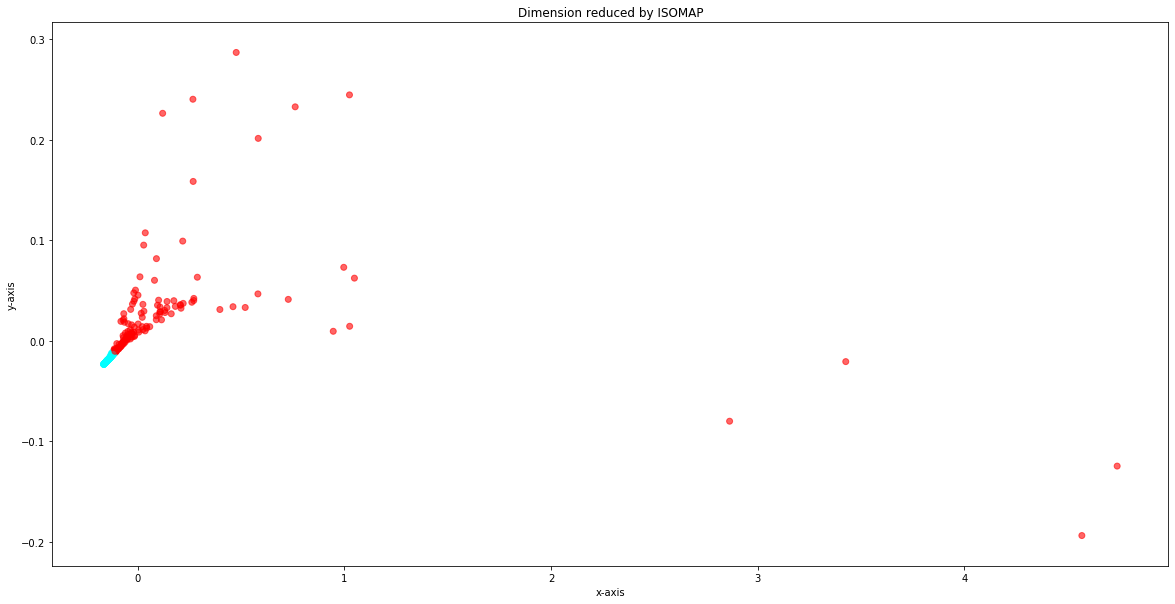

In [198]:
plot_isomap(XQ1, perHourElectricityConsumptionEachBuildingWholeYear, neighbor=10, dimension=2)

In [199]:
print("silhouette score on euclidean metric: ",silhouette_score(XQ1, spectralCluster.labels_))
print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, spectralCluster.labels_))
print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, spectralCluster.labels_))

silhouette score on euclidean metric:  0.32978073904237576
calsinki-H score on euclidean metric:  35.88687287968647
davis-B score on euclidean metric:  1.0646654336373946


In [200]:
def perform_spectral_cluster_quarter_wise(quarter_no=1, ncl  = 8,train=None):
    wholeYear = copy.deepcopy(train)
    if quarter_no>0:
        wholeYear["quarter"] = wholeYear["timestamp"].dt.quarter
        wholeYear = wholeYear[wholeYear["quarter"]==quarter_no]
    wholeYear.fillna(0, inplace=True)
    
    perHourElectricityConsumptionEachBuilding = wholeYear.pivot(values="meter_reading", index="building_id", columns="timestamp")
    perHourElectricityConsumptionEachBuilding.fillna(0, inplace=True)
    XQ1 = MinMaxScaler().fit_transform(perHourElectricityConsumptionEachBuilding.values.copy())
    spectralCluster = SpectralClustering(n_clusters=ncl, n_init=10, assign_labels="kmeans", n_jobs=-1,eigen_solver="arpack", )
    print("params: ", spectralCluster.get_params)
    cluster_found_q1 = spectralCluster.fit_predict(XQ1)
    cluster_found_sr_q1 = pd.Series(cluster_found_q1, name="cluster")
    perHourElectricityConsumptionEachBuilding.set_index(cluster_found_sr_q1, append=True, inplace=True)
    plot_isomap(XQ1, perHourElectricityConsumptionEachBuilding, neighbor=8, dimension=2)
    
    print("silhouette score on euclidean metric: ",silhouette_score(XQ1, spectralCluster.labels_))
    print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(XQ1, spectralCluster.labels_))
    print("davis-B score on euclidean metric: ",davies_bouldin_score(XQ1, spectralCluster.labels_))
    return 

### Spectral clustering on quarter 1

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.9321426645457576
calsinki-H score on euclidean metric:  118.51929612416036
davis-B score on euclidean metric:  0.04323121727913015


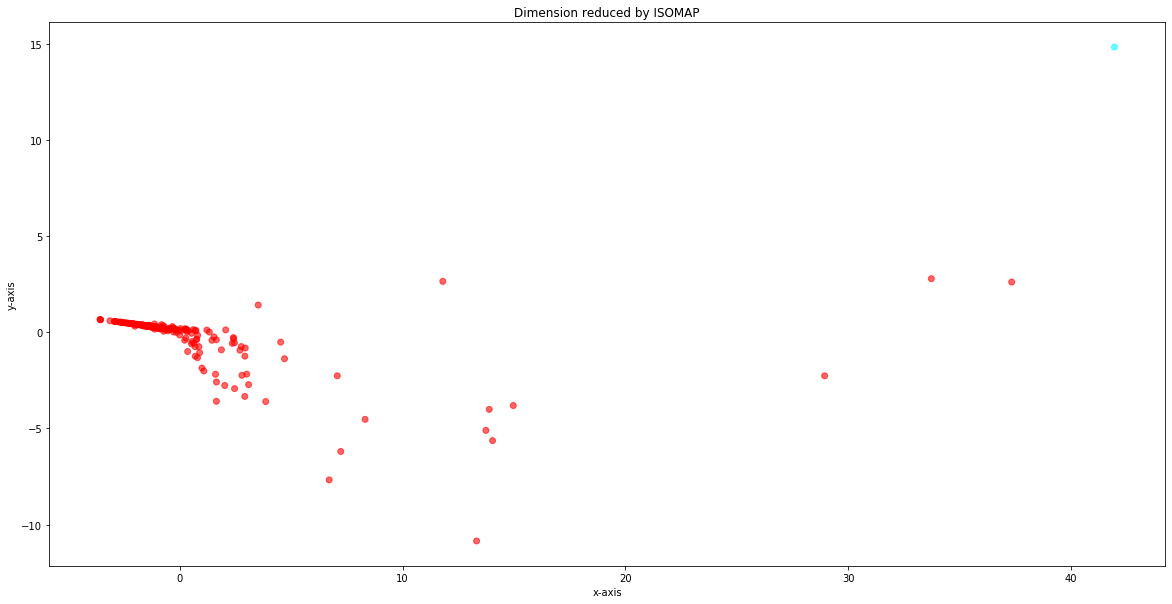

In [201]:
perform_spectral_cluster_quarter_wise(1,2, train)

### Spectral clustering on quarter 2

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.9309951057420903
calsinki-H score on euclidean metric:  98.20435454009662
davis-B score on euclidean metric:  0.045773759831417085


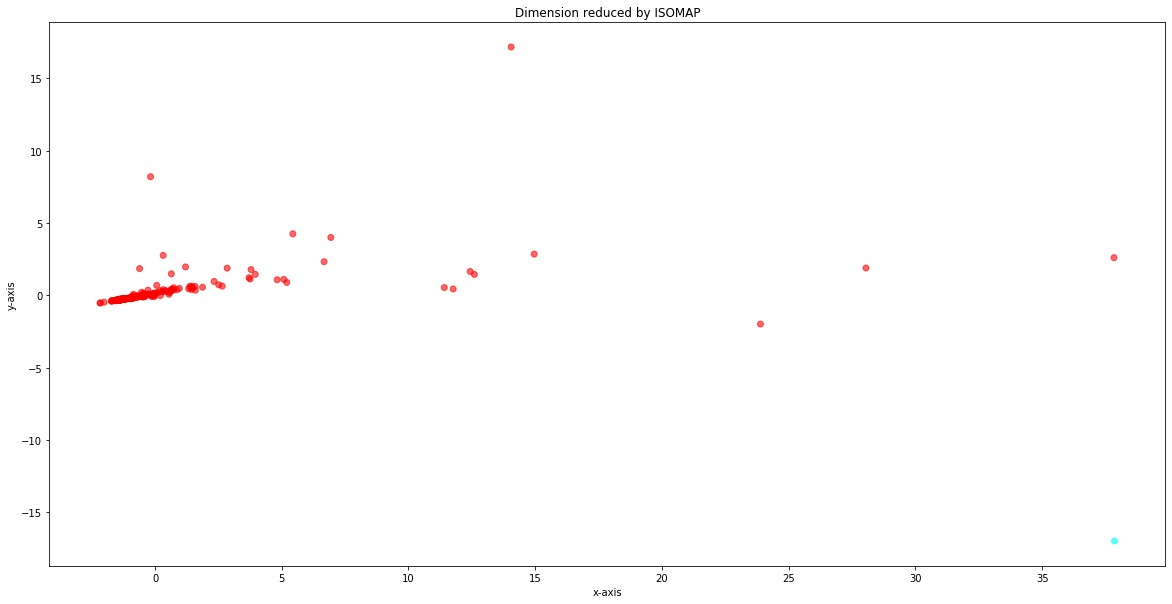

In [202]:
perform_spectral_cluster_quarter_wise(2,2, train)

### Spectral clustering on quarter 3

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.9435431560565665
calsinki-H score on euclidean metric:  106.18212772108153
davis-B score on euclidean metric:  0.03668712008581767


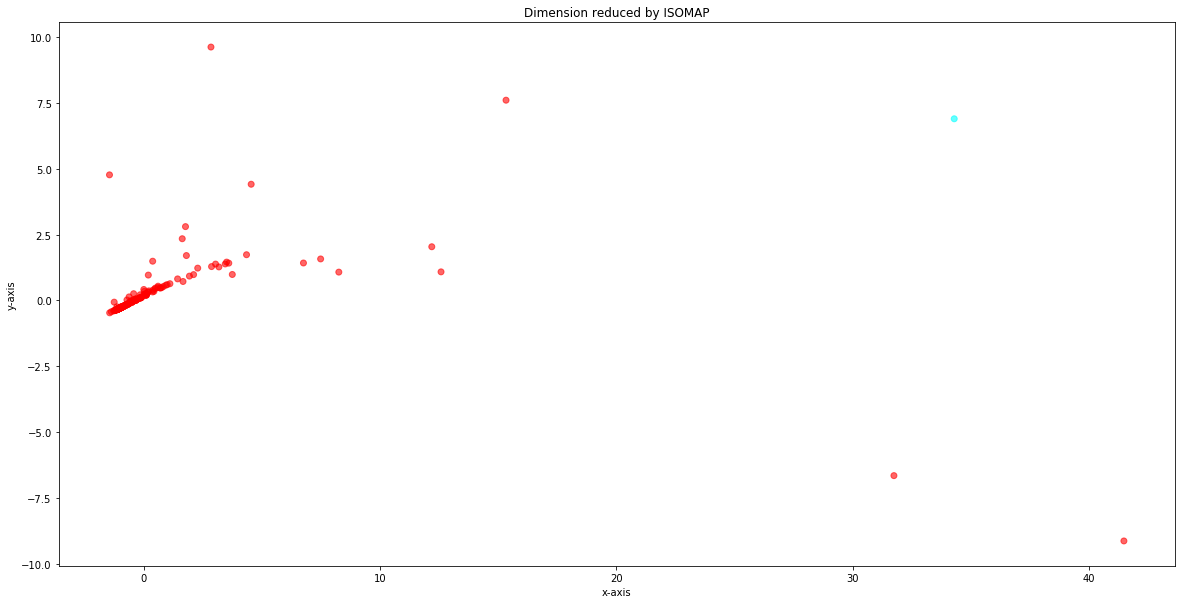

In [203]:
perform_spectral_cluster_quarter_wise(3,2, train)

### Spectral clustering on quarter 4

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>
silhouette score on euclidean metric:  0.9420646304266285
calsinki-H score on euclidean metric:  856.668290640412
davis-B score on euclidean metric:  0.3047065274050644


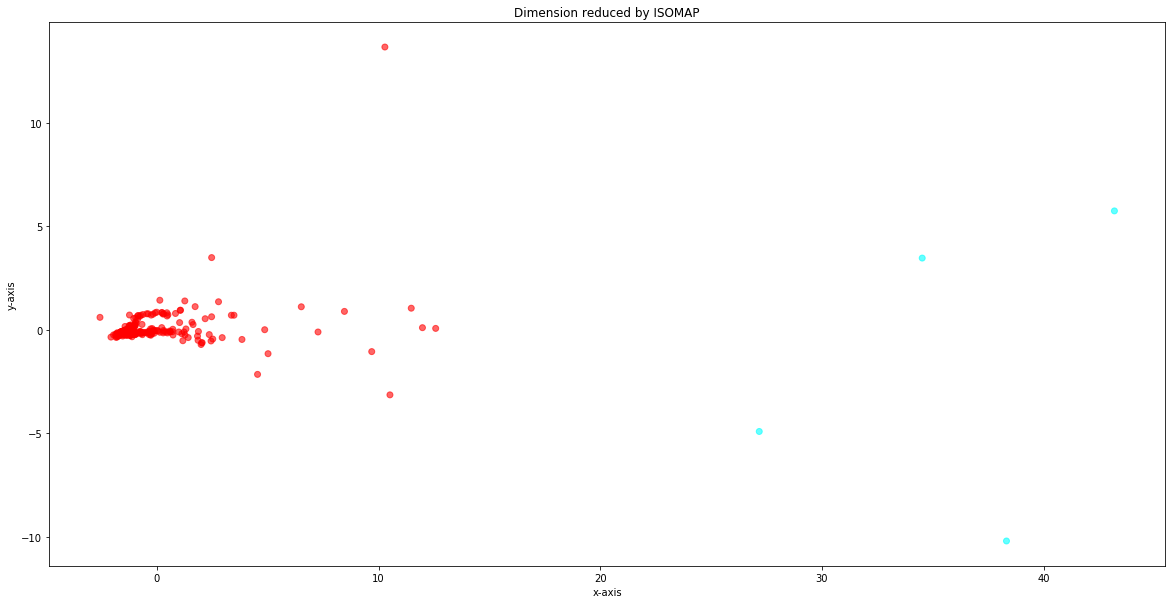

In [204]:
perform_spectral_cluster_quarter_wise(4,2, train)

### Spectral clustering on whole year - function testing part - can be ignored

params:  <bound method BaseEstimator.get_params of SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver='arpack', eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=8, n_init=10, n_jobs=-1,
                   n_neighbors=10, random_state=None)>


C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\ashuk\.conda\envs\udacityDL\lib\site-packages\sklearn\cluster\spectral.py:268: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  n_init=n_init)


silhouette score on euclidean metric:  0.9110619040033218
calsinki-H score on euclidean metric:  90.99464778586163
davis-B score on euclidean metric:  0.05193261896226228


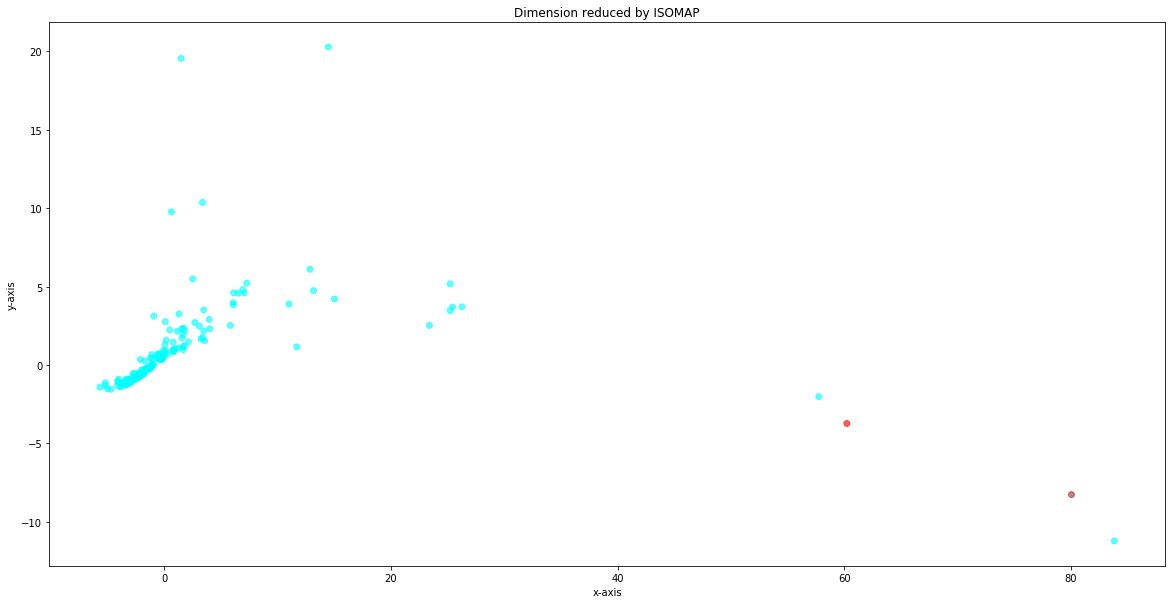

In [205]:
perform_spectral_cluster_quarter_wise(0, train=train)

### Perform Agglomerative clustering and see if any pattern can be extracted.

In [206]:
def plot_scipy_edndogram(pivot=None):
    z = sch.linkage(MinMaxScaler().fit_transform(pivot.values),"ward")
    plt.figure(figsize=(20,10))
    a = sch.dendrogram(z, show_leaf_counts=False,leaf_font_size=12.,show_contracted=True, leaf_rotation=90)
    return

def performAgglomerativeClustering(ncl = 2, affinity="euclidean", linkage="ward", X=None, pivot=None):
    AGModel = AgglomerativeClustering(n_clusters=ncl,affinity=affinity, linkage=linkage)
    x = MinMaxScaler().fit_transform(X)
    cluster_found = AGModel.fit_predict(x)
    #pivot.set_index("building_id", inplace=True)
    cluster_found = pd.Series(cluster_found, name="cluster")
    pivot.set_index(cluster_found, append=True, inplace=True)
    print("silhouette sample on euclidean metric: ",silhouette_samples(x, cluster_found))
    print("silhouette score on euclidean metric: ",silhouette_score(x, cluster_found))
    print("calsinki-H score on euclidean metric: ",calinski_harabasz_score(x, cluster_found))
    print("davis-B score on euclidean metric: ",davies_bouldin_score(x, cluster_found))
    plot_isomap(x, pivot)
    plot_kernel_pca(x, pivot=pivot, kernel="rbf", g=15,rzev=True, deg = 1)
    plot_tsne(x, pivot)
    plot_umap(x, pivot)
    return pivot

def generate_dtw_matrix(pivot=None):
    from dtaidistance import dtw
    mat = dtw.distance_matrix(pivot)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if i == j:
                mat[i,j] = 0
            else:
                mat[j,i] = mat[i,j]
    return mat

def generate_quarter_pivot_matrix(quarter_no = 0,pivot=None):
    quarter1 = copy.deepcopy(train)
    if quarter_no>0:
        quarter1["quarter"] = quarter1["timestamp"].dt.quarter
        quarter1 = quarter1[quarter1["quarter"]==quarter_no]
    quarter1["meter_reading"].fillna(0, inplace=True)
    
    if quarter_no>0:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot_table(values="meter_reading", index="building_id", columns="hour", aggfunc={"meter_reading":np.mean})
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    else:
        perHourElectricityConsumptionEachBuildingQ1 = quarter1.pivot(values="meter_reading", index="building_id", columns="timestamp")
        perHourElectricityConsumptionEachBuildingQ1.fillna(0, inplace=True)
    return perHourElectricityConsumptionEachBuildingQ1

In [207]:
aggTrain = copy.deepcopy(train)

### Pivot over whole year data

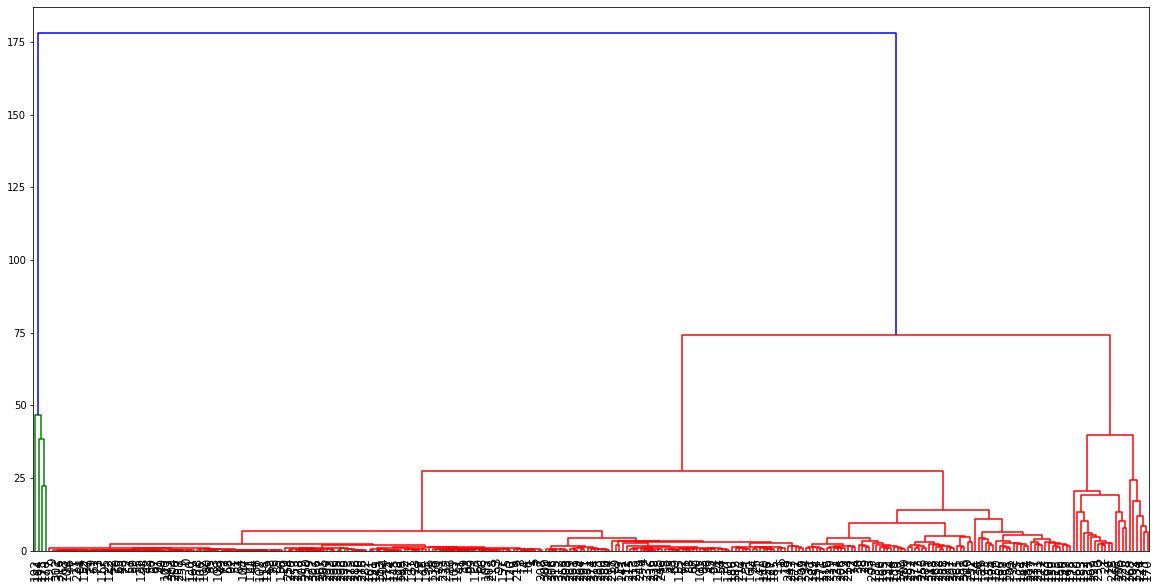

In [208]:
pivot = generate_quarter_pivot_matrix(0,aggTrain)
plot_scipy_edndogram(pivot = pivot)

silhouette sample on euclidean metric:  [0.96632862 0.96678365 0.88463916 0.96754549 0.96737722 0.96658247
 0.96405252 0.96542599 0.96725198 0.96579202 0.90200821 0.96044202
 0.95925464 0.96310761 0.96709043 0.96674153 0.96705866 0.96583995
 0.96494117 0.96515894 0.96373725 0.87307963 0.95522389 0.96709475
 0.96475942 0.96037761 0.91322161 0.96556401 0.95115023 0.94687019
 0.94450263 0.96589233 0.93684983 0.9517981  0.95283988 0.96715155
 0.96153233 0.9660489  0.96603113 0.96746843 0.96658283 0.96707899
 0.96677767 0.96631459 0.96694838 0.9671516  0.96590106 0.9675117
 0.9663283  0.96671859 0.96671402 0.96691085 0.96641869 0.9667361
 0.96557744 0.96654908 0.96680755 0.96638557 0.96685485 0.96643943
 0.96772831 0.96610965 0.96718603 0.96757168 0.96705071 0.96632576
 0.96744215 0.96666696 0.96688346 0.96739092 0.96667872 0.96663338
 0.96662163 0.96607484 0.9589735  0.96705637 0.96712606 0.96646132
 0.96635095 0.96606411 0.96673812 0.96749524 0.96665796 0.96733423
 0.96615906 0.96705086 0

,timestamp,2016-01-01 00:00:00,2016-01-01 01:00:00,2016-01-01 02:00:00,2016-01-01 03:00:00,2016-01-01 04:00:00,2016-01-01 05:00:00,2016-01-01 06:00:00,2016-01-01 07:00:00,2016-01-01 08:00:00,2016-01-01 09:00:00,...,2016-12-31 14:00:00,2016-12-31 15:00:00,2016-12-31 16:00:00,2016-12-31 17:00:00,2016-12-31 18:00:00,2016-12-31 19:00:00,2016-12-31 20:00:00,2016-12-31 21:00:00,2016-12-31 22:00:00,2016-12-31 23:00:00
building_id,cluster,,,,,,,,,,,,,,,,,,,,,
745,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,9.8624,0.000,27.0749,1.4999,1.4999
747,0,120.7860,114.9840,149.8020,122.8130,138.3530,138.8310,134.6090,142.8090,141.4880,115.2820,...,596.7410,596.7410,596.7410,596.7410,596.7410,596.7410,596.741,596.7410,596.7410,596.7410
750,0,4678.1400,4795.7200,4643.7200,4807.1900,4543.8300,4778.5100,4828.2200,4666.6700,4861.2000,4614.5700,...,3964.5300,4020.9300,4112.7000,4134.2100,4066.3400,4154.7600,4106.970,3950.6700,3951.6300,3998.9500
751,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,207.6430,206.3520,205.9020,205.0730,210.1810,209.4050,208.553,208.2260,207.3620,207.7610
753,0,324.2260,324.2260,323.5380,322.8500,324.2260,323.0790,322.8500,322.8500,322.3910,322.8500,...,323.5380,323.3090,323.3090,323.5380,323.3090,323.3090,323.079,323.3090,323.5380,323.0790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,0,1019.1400,1012.2900,929.4500,866.6880,1010.3300,1012.2600,1049.6000,1149.0800,1338.1400,1255.2400,...,270.7080,277.3150,284.6910,284.5260,279.3370,271.7060,273.957,264.4370,258.0100,259.0730
1436,0,1082.9500,1090.9400,1117.6500,1132.8500,1207.8100,1109.5800,1363.7700,1971.9800,1988.4300,1966.5900,...,1340.6100,1480.0800,1758.7700,1704.1300,1562.1200,1710.7600,1571.000,1505.7700,1265.0300,1274.6600
1437,0,1790.1500,1743.6500,1663.0400,1577.4200,1599.3400,1632.5300,1595.8200,1812.7000,1815.8300,1859.3900,...,1640.3500,1553.6600,1539.5500,1681.0100,1703.8800,1748.1900,1734.630,1714.7000,1670.3700,1518.9200


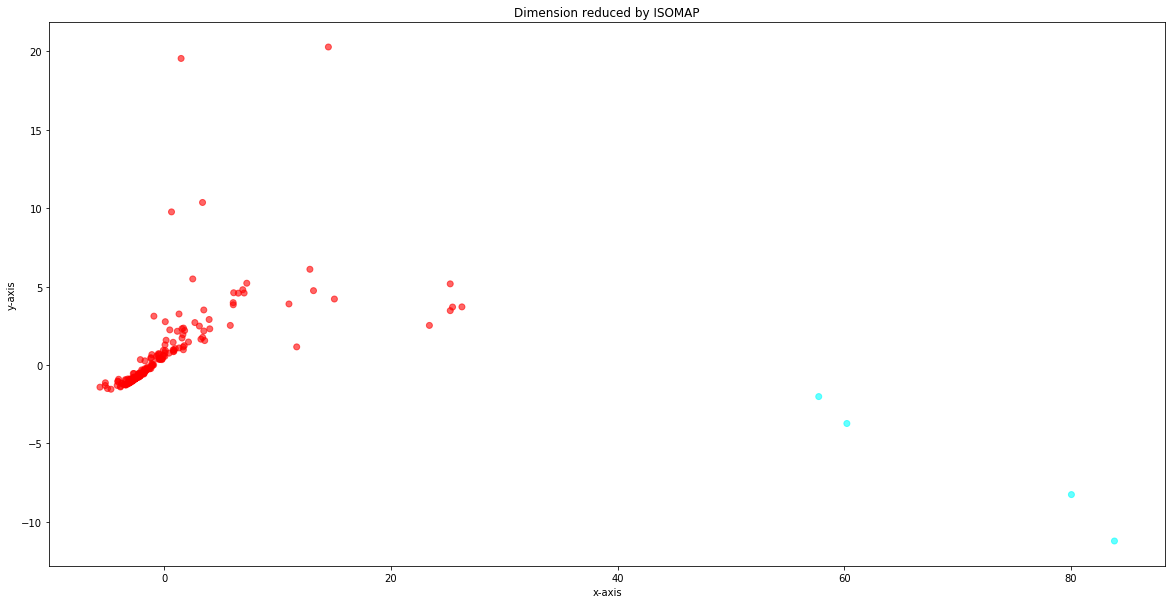

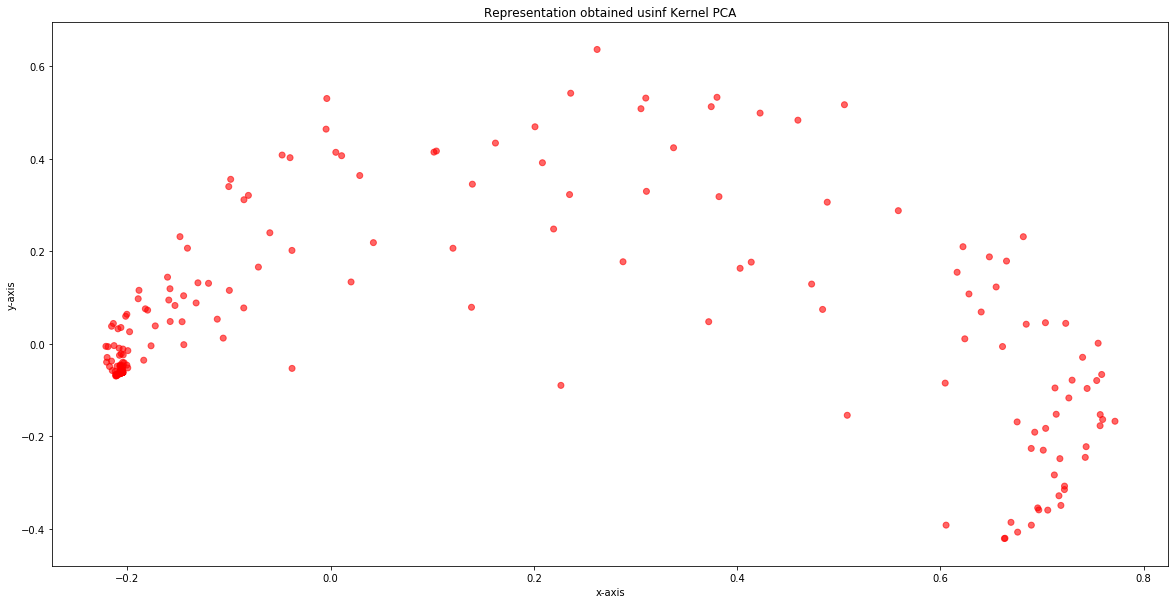

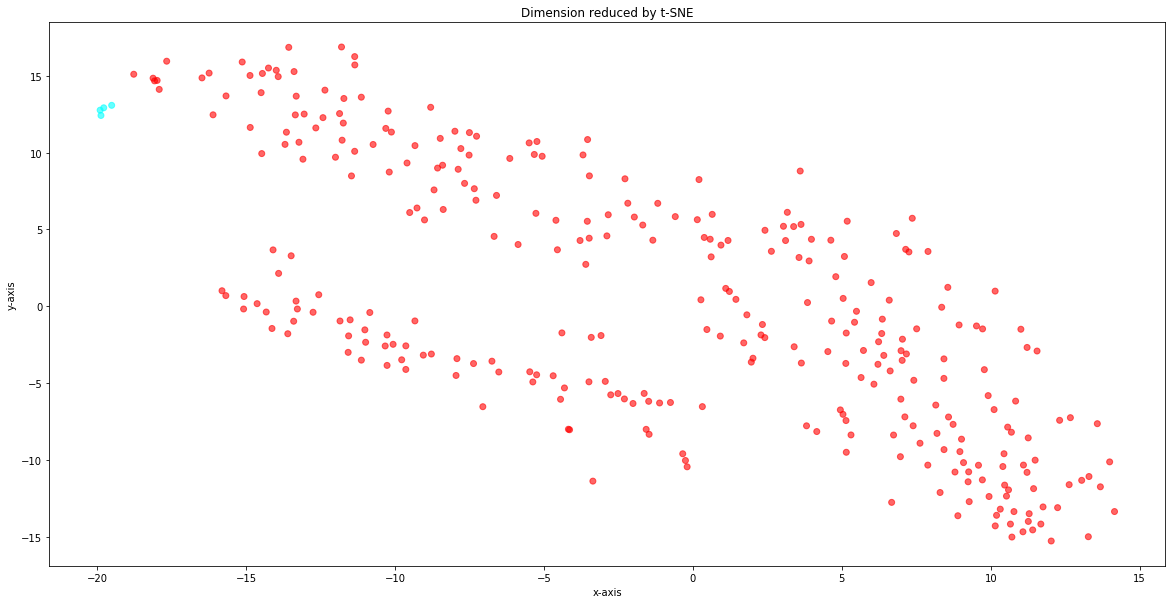

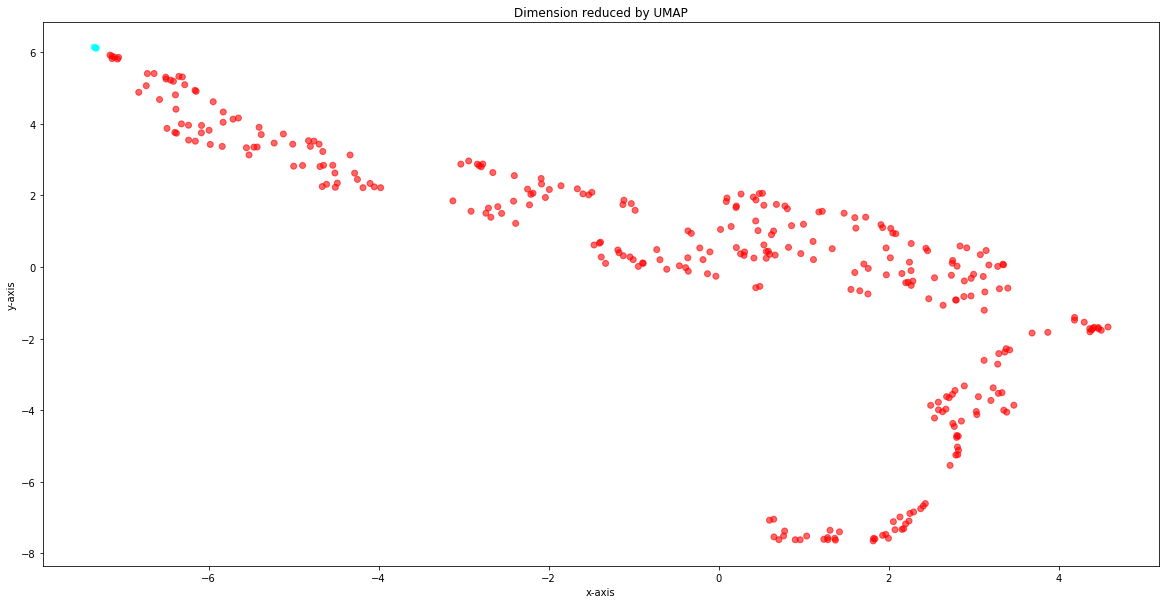

In [209]:
performAgglomerativeClustering(ncl=2, X=pivot.values, pivot=pivot)

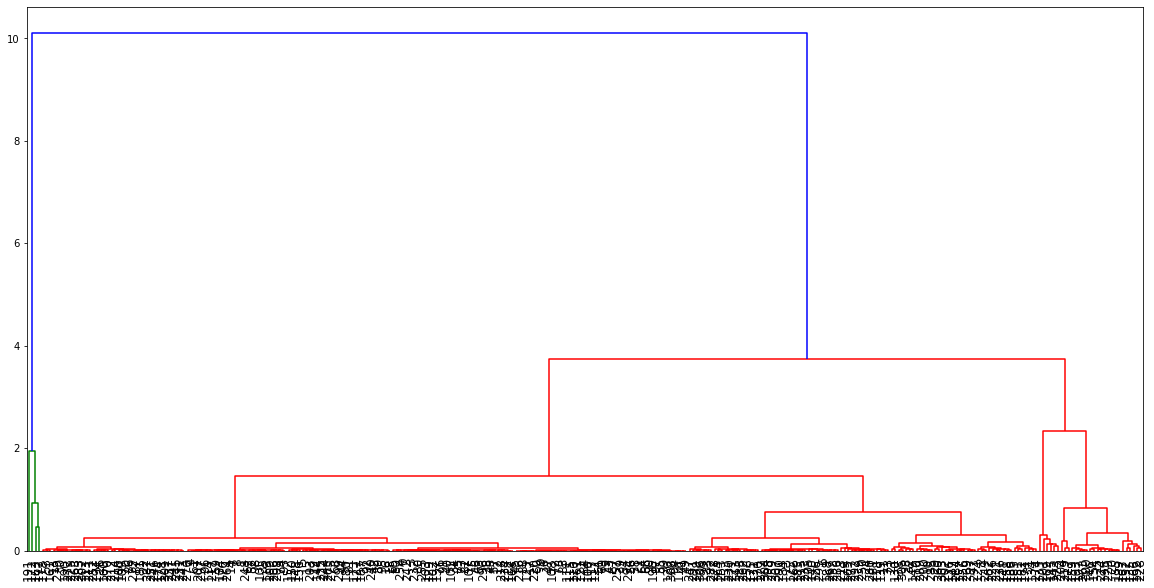

In [210]:
pivot = generate_quarter_pivot_matrix(1,aggTrain)
plot_scipy_edndogram(pivot = pivot)


silhouette sample on euclidean metric:  [0.9699169  0.97162402 0.92898276 0.9704391  0.97192776 0.97138199
 0.97081677 0.97160238 0.97168314 0.96858074 0.94949211 0.96895906
 0.97098237 0.97150588 0.97178012 0.97161492 0.97201717 0.96832351
 0.97194461 0.97185897 0.92395387 0.962114   0.97222667 0.97052501
 0.96727553 0.91811611 0.97159087 0.95688379 0.95226672 0.94923744
 0.97172348 0.94352308 0.95682516 0.96010846 0.97065078 0.97133025
 0.96859655 0.97198432 0.97086851 0.96914845 0.97053507 0.96959588
 0.9716317  0.96978899 0.97214122 0.96840792 0.97056748 0.96854878
 0.97077669 0.96950559 0.97013854 0.96962112 0.97117969 0.97115602
 0.96920129 0.96940452 0.96904174 0.97076785 0.96914012 0.97152282
 0.96857143 0.97196196 0.97121244 0.97057083 0.96896194 0.97087571
 0.9692708  0.96973342 0.97211518 0.96975334 0.97219839 0.969067
 0.96880145 0.96880158 0.97125969 0.97035477 0.97031048 0.97048808
 0.96875118 0.96967543 0.97025966 0.9722082  0.97048327 0.96866346
 0.9698652  0.97060778 0

,hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
building_id,cluster,,,,,,,,,,,,,,,,,,,,,
745,0,10.645414,11.308243,12.601478,28.327356,18.091427,17.473429,22.236720,199.817978,231.428001,223.147112,...,151.167005,157.136783,159.138193,159.444087,162.392636,161.413012,168.761837,167.773926,32.340286,8.791755
747,0,235.543596,244.894470,244.907003,249.171163,254.337734,249.329254,260.294715,435.691409,447.320040,409.036812,...,306.730962,313.908195,317.614658,232.614767,227.269146,235.350698,242.543705,221.121059,245.297052,230.394741
750,0,4062.343407,4028.770000,4038.570556,4047.462308,4059.790989,4132.216044,4206.221319,4280.431538,4255.057033,4170.195714,...,4020.310769,3832.281648,3764.331099,3757.566044,3795.126703,3868.837802,3865.923703,3905.261099,3957.211978,4025.766374
751,0,127.673055,127.661824,126.812711,133.863077,127.627077,127.673451,127.449857,146.862209,162.972622,165.505000,...,147.140725,144.462846,142.838791,139.819516,138.402538,137.404714,137.267747,133.225242,130.663341,130.126132
753,0,334.833110,329.633865,324.994121,328.451164,318.421296,312.380769,313.917275,316.266319,349.977231,388.162923,...,344.743231,332.884890,328.663132,325.605758,319.516286,321.283165,325.331516,322.810484,331.684066,334.915286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,0,1038.063581,1057.795116,1068.968651,1104.450791,1074.934302,1176.567698,1389.258690,1497.388405,1539.078333,1411.425500,...,1093.863143,1106.258362,1105.847981,1124.668817,1180.194533,1175.833286,1060.527990,1033.323421,1061.254488,1020.789651
1436,0,1844.323628,1527.776581,1514.535977,1549.216744,1561.040233,1560.542233,2007.723452,3233.930476,3273.244286,2947.130000,...,2443.094810,2432.914952,2349.006881,2389.598024,2461.942952,2513.736286,2559.130524,2551.304786,2491.496837,2153.217953
1437,0,1938.326070,1941.903093,1956.136814,1995.375023,2016.300023,2101.307163,2161.136095,2143.421738,2159.251610,2082.145714,...,1715.361524,1677.456024,1670.508262,1752.009286,1804.927667,1825.203714,1870.115952,1886.670643,1866.055047,1869.745860


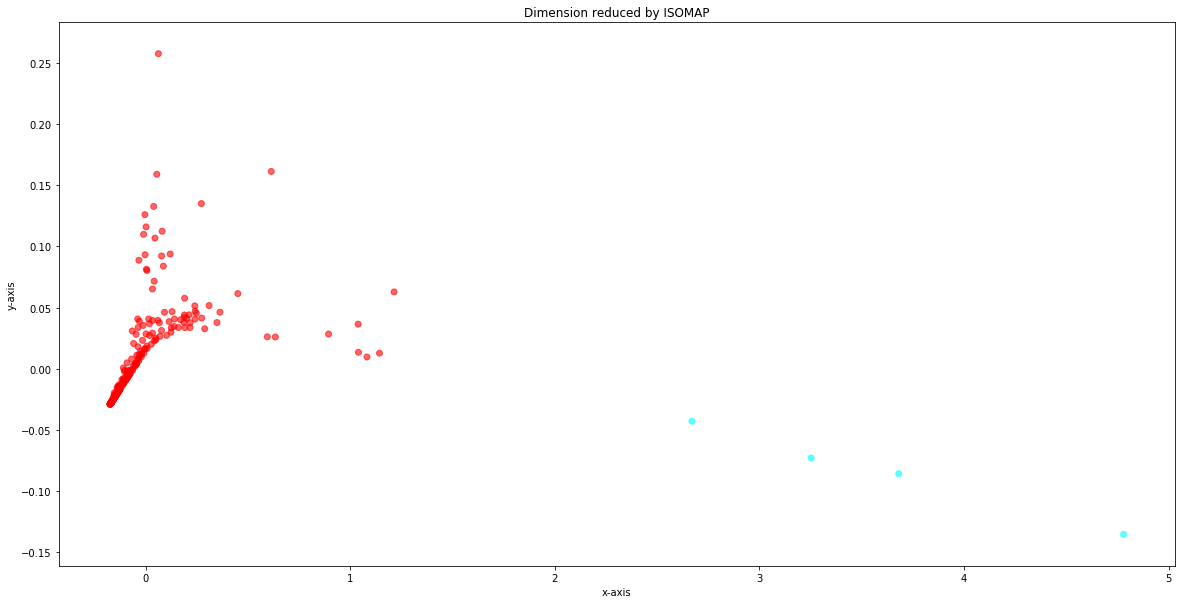

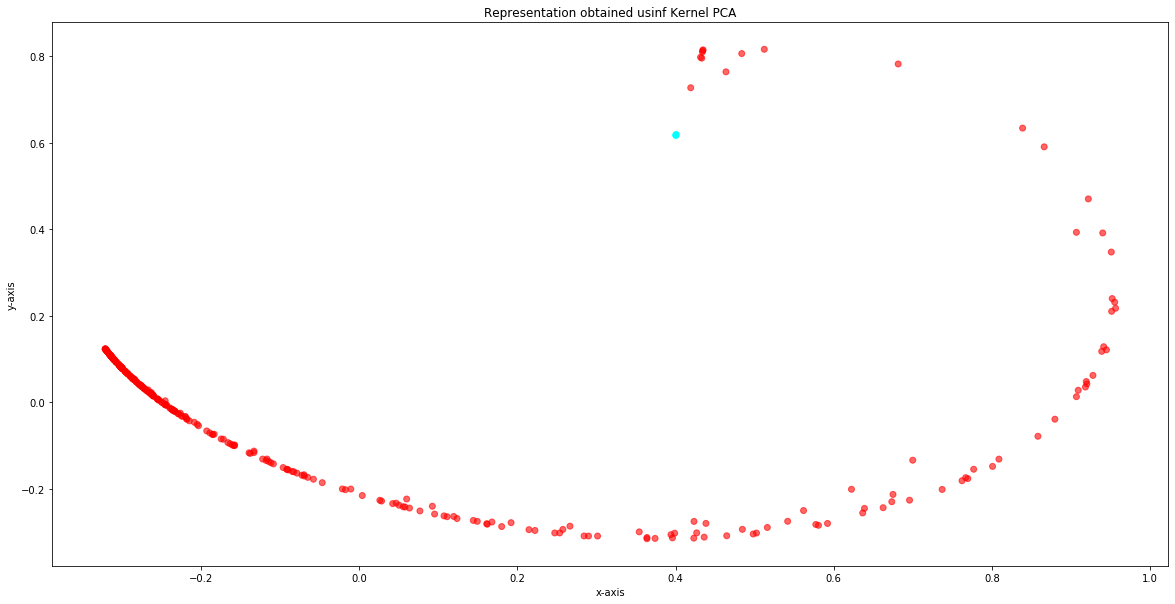

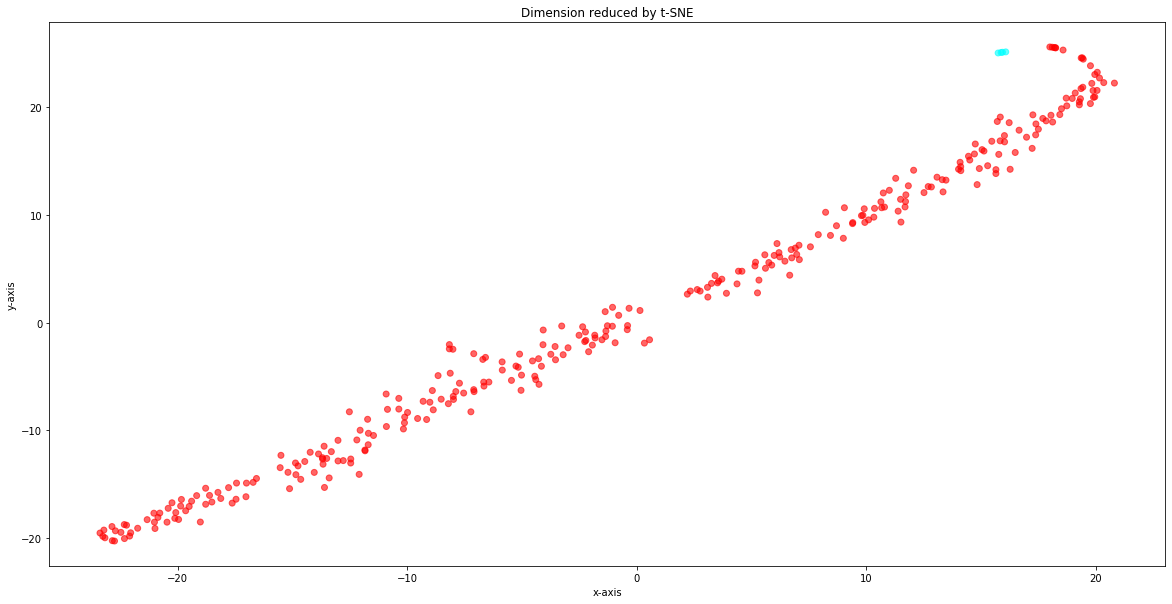

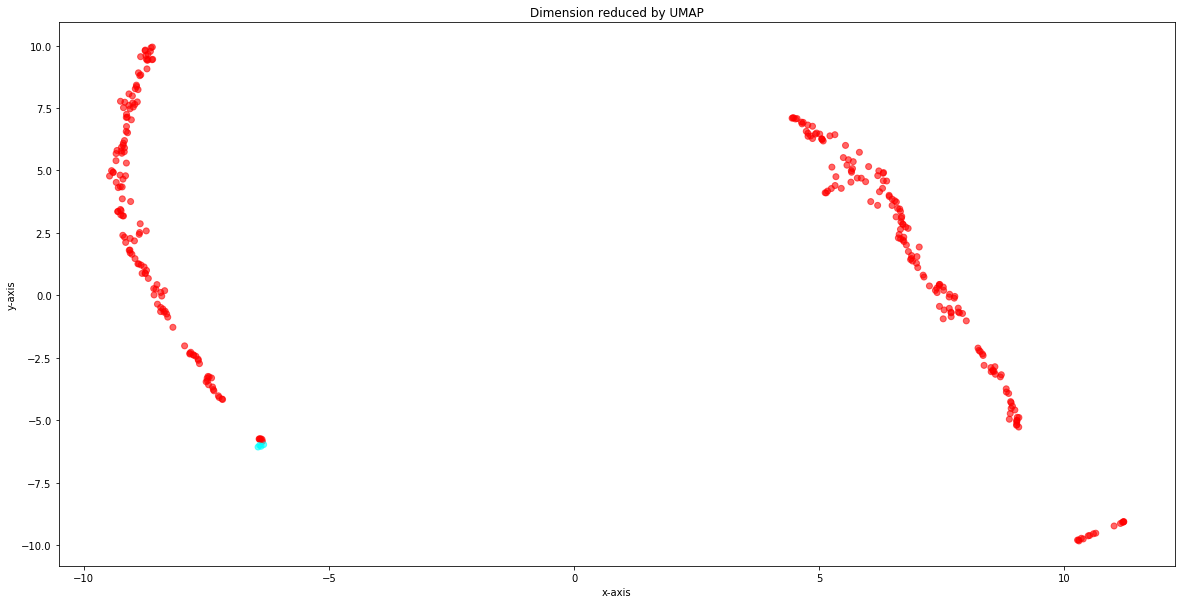

In [211]:
performAgglomerativeClustering(ncl=2, X=pivot.values, pivot=pivot)

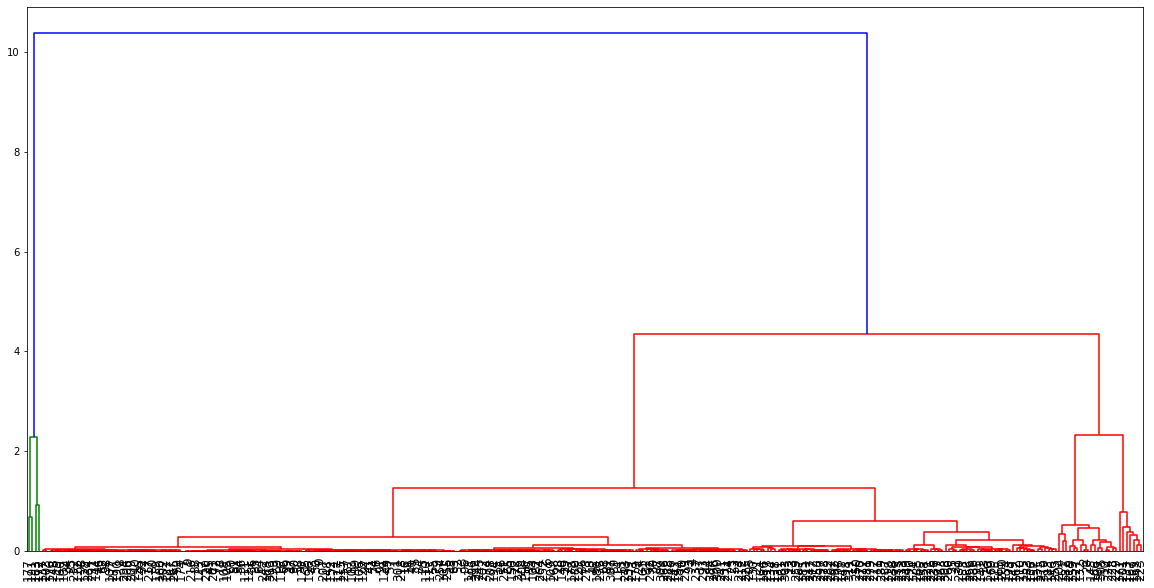

In [212]:
pivot = generate_quarter_pivot_matrix(2,aggTrain)
plot_scipy_edndogram(pivot = pivot)


silhouette sample on euclidean metric:  [ 0.92933248  0.927439    0.29494621  0.93490123  0.93025688  0.9282634
  0.93416897  0.92248376  0.93215408  0.92248376 -0.07096872  0.88513666
  0.8857874   0.90502662  0.93104007  0.93093951  0.93029711  0.92259011
  0.93180448  0.93104866  0.26104781  0.89220456  0.9350373   0.92963862
  0.91843201  0.82148484  0.9332796   0.92963571  0.91946771  0.92641711
  0.92390955  0.84203984  0.91551811  0.84359479  0.93319546  0.92645659
  0.92501877  0.92669446  0.93226484  0.92668097  0.93095773  0.92762044
  0.93431699  0.92949481  0.93109578  0.92306818  0.93264227  0.92655898
  0.92970684  0.92728058  0.93048127  0.92424916  0.93509986  0.92958763
  0.92749112  0.93008262  0.92541824  0.92771675  0.92603874  0.93465773
  0.92440005  0.93420849  0.93264209  0.92943511  0.92583867  0.93339326
  0.9264807   0.9284009   0.93335628  0.92622812  0.93213044  0.92888393
  0.92366844  0.90715497  0.9334037   0.93062287  0.92683163  0.93397275
  0.92362861

,hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
building_id,cluster,,,,,,,,,,,,,,,,,,,,,
745,2,27.618700,15.321400,23.724967,18.637417,23.174950,26.042125,89.562617,105.013095,99.693917,93.142318,...,73.560287,81.315789,64.626583,70.679975,78.967167,79.631893,64.984947,67.610191,24.881870,35.337467
747,2,39.200814,22.467090,34.424378,36.731257,60.537538,40.754857,33.802419,73.478689,60.661851,53.523616,...,35.909856,27.584022,29.172881,7.232519,4.325422,9.855679,14.341044,15.492225,47.127068,40.558800
750,0,3834.526374,3847.148242,3862.081429,3848.582198,3870.741758,3855.766923,3886.730220,3888.794835,3827.086538,3937.489505,...,4021.285670,3901.904297,3837.642516,3875.564066,3881.798132,3840.604396,3851.765714,3824.358791,3837.080440,3820.088462
751,2,202.089714,201.106901,200.822088,200.435132,199.922426,198.514527,198.974225,203.352896,204.369626,203.882460,...,200.269101,200.756252,200.516886,200.338466,201.529264,202.260725,202.059198,202.018440,201.977011,202.046527
753,2,320.548648,320.200824,321.057769,319.656385,320.593978,319.466000,319.953780,317.715571,321.830187,327.270747,...,324.566297,323.784923,323.931110,323.875670,323.767275,322.801934,322.169319,321.168648,321.534132,321.183802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,2,312.940857,332.767116,345.188122,367.417126,370.177858,396.087847,540.126426,578.164509,536.647048,465.974592,...,322.816937,326.947087,285.757256,257.447114,254.920782,284.363551,302.757045,335.961047,319.783086,312.528016
1436,2,883.830626,565.867938,513.317922,508.644137,486.290532,512.928922,830.658733,1610.583604,1771.534956,1537.371088,...,1188.264868,1177.904231,1058.153297,1000.756154,955.744099,988.852385,1078.173374,1134.109132,1161.665703,999.112055
1437,2,753.225967,784.683341,801.312637,830.740165,876.956703,912.163736,951.779497,951.646989,909.323158,828.818700,...,628.487890,604.283593,582.016648,582.554659,587.270445,608.825462,675.307527,707.229912,710.104945,703.533846


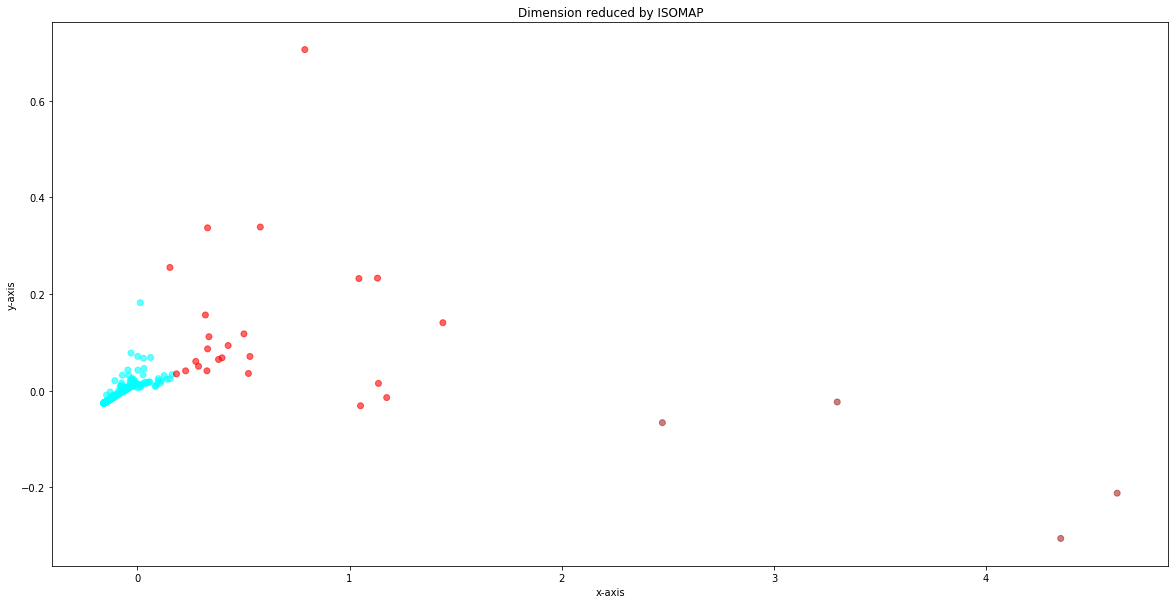

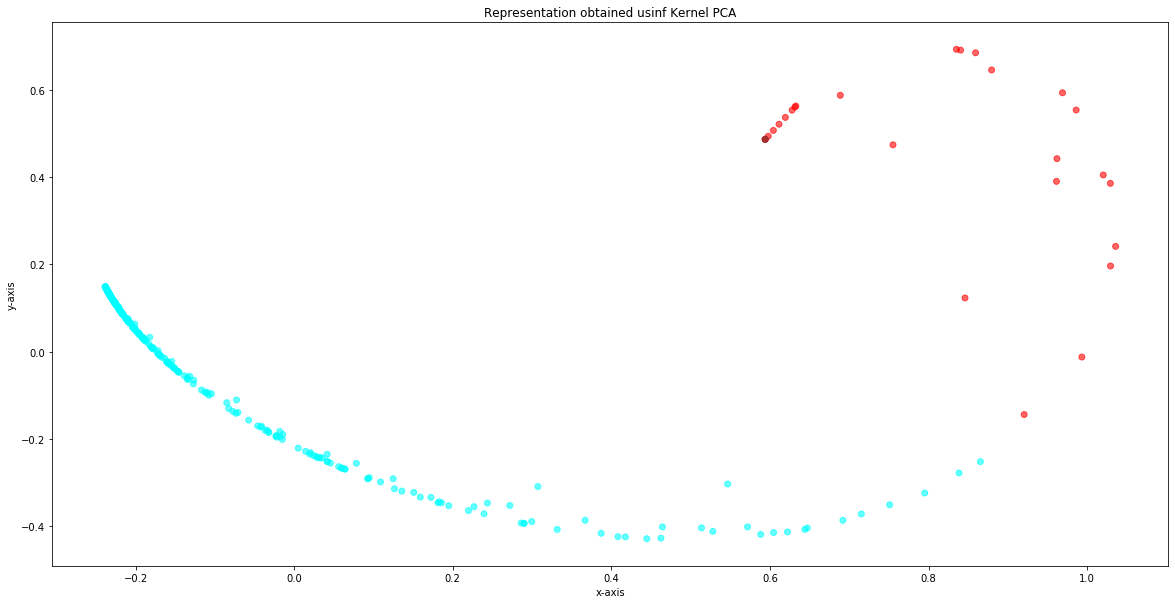

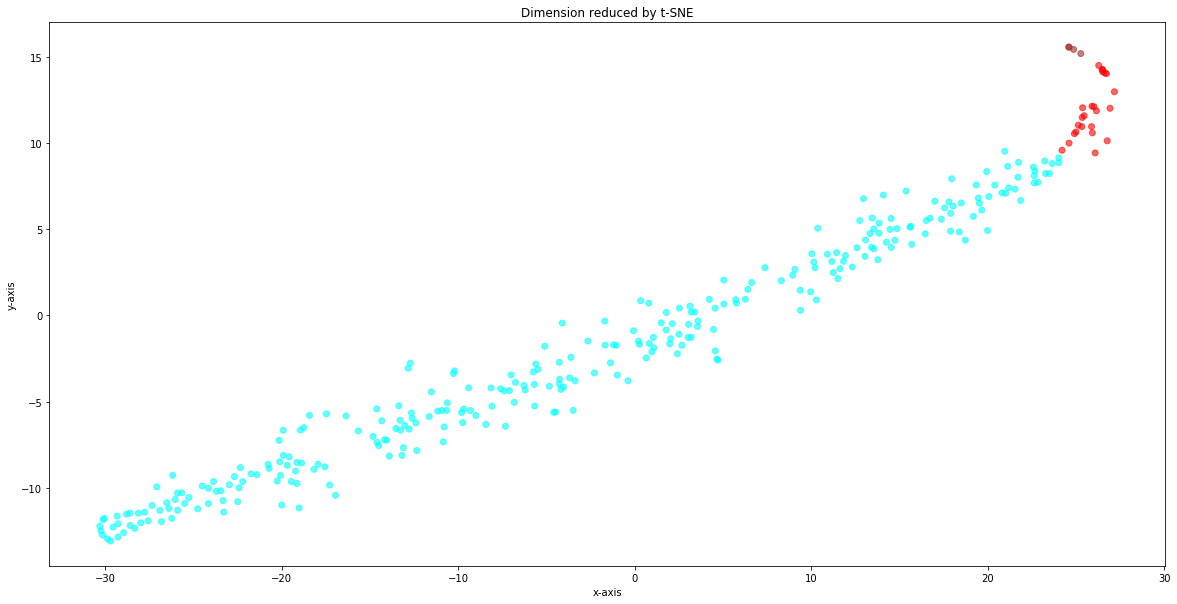

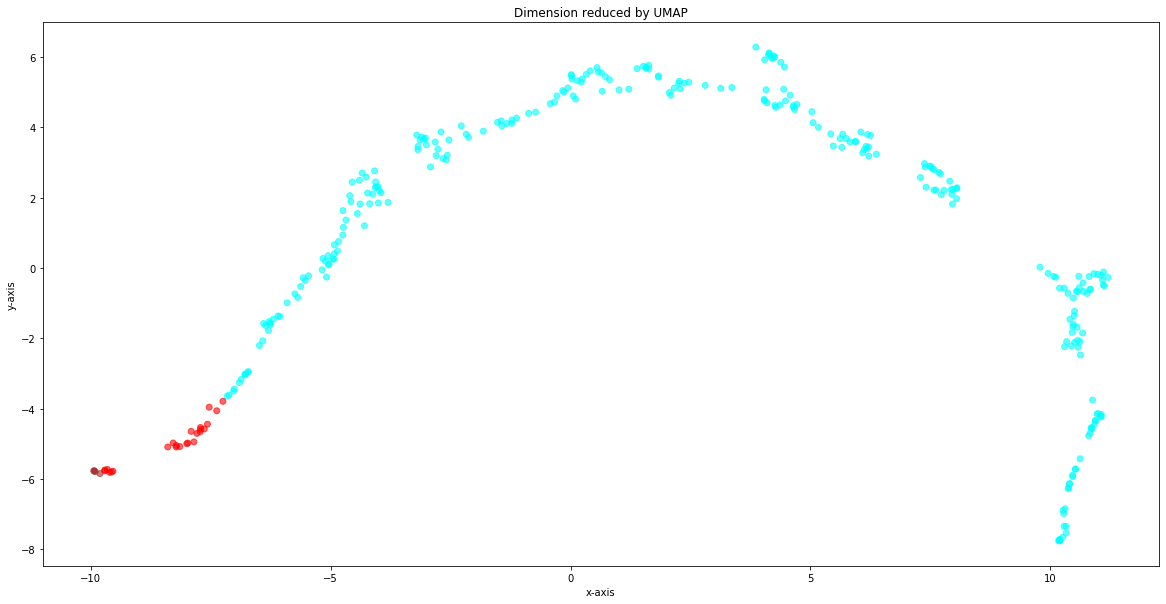

In [213]:
performAgglomerativeClustering(ncl=3, X=pivot.values, pivot=pivot)

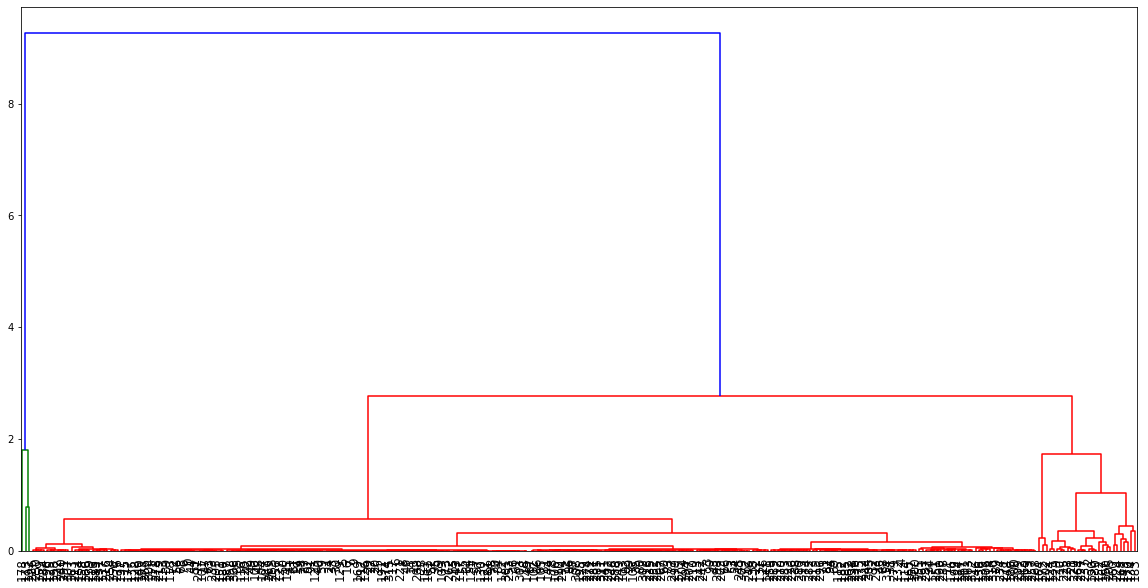

In [214]:
pivot = generate_quarter_pivot_matrix(3,aggTrain)
plot_scipy_edndogram(pivot = pivot)


silhouette sample on euclidean metric:  [0.9854746  0.98496855 0.94726309 0.985644   0.98509627 0.98492689
 0.98493501 0.98492689 0.98495626 0.98492689 0.93425582 0.9812854
 0.98583002 0.9852342  0.98494405 0.98550119 0.98492689 0.98493941
 0.98511513 0.98533564 0.98492683 0.92157156 0.98524122 0.9849572
 0.98493377 0.98492683 0.98487162 0.98492683 0.98499631 0.98492683
 0.98492801 0.98496695 0.9853941  0.9849307  0.97975311 0.98574626
 0.98511457 0.9852406  0.98446423 0.98557717 0.98534691 0.98529625
 0.98540215 0.98549284 0.98547638 0.98511732 0.98496169 0.98567279
 0.98542454 0.9854206  0.98525133 0.98561911 0.98505339 0.98569909
 0.98572495 0.98523926 0.98551163 0.98525549 0.98529928 0.98535278
 0.98578941 0.9850894  0.98570039 0.98566465 0.98522713 0.98520089
 0.98570772 0.98531595 0.98552773 0.98542817 0.98515254 0.98535501
 0.98555319 0.98501531 0.98444352 0.98562126 0.98552958 0.98529149
 0.98577721 0.98504199 0.98575794 0.98581523 0.98542238 0.98578338
 0.9851635  0.98547714 0

,hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
building_id,cluster,,,,,,,,,,,,,,,,,,,,,
745,0,97.781200,39.299900,30.506150,63.918650,46.504100,10.424950,11.474900,46.649843,71.575413,84.996833,...,46.143625,48.274125,38.383256,55.595761,47.159933,49.546241,63.380889,35.803754,19.959300,23.437400
747,0,0.504476,0.000000,21.999370,7.790380,0.578860,8.252698,1.509957,1.963433,2.878835,2.401446,...,0.679779,1.346674,1.209652,0.454470,0.178186,0.474948,0.000000,0.612274,0.876721,9.769835
750,0,2288.786413,2278.813696,2294.901087,2287.726957,2303.317500,2279.362065,2280.484457,2270.093696,2329.689239,2424.721630,...,2607.653696,2543.152500,2468.143152,2402.173478,2361.551739,2351.971522,2308.882283,2243.473261,2242.418261,2254.725978
751,0,199.914522,199.887815,199.852641,199.827902,199.479598,199.746696,199.643826,199.552967,199.098087,199.619402,...,199.569609,199.921011,199.904880,199.850891,199.750543,199.746609,199.824717,199.934717,199.968587,199.942000
753,0,262.377533,260.016707,263.113022,265.698359,260.756413,257.663134,250.570361,248.239250,311.273902,326.058402,...,314.351913,305.408261,303.678027,308.130682,291.110402,285.403696,274.134902,265.035217,264.606413,272.796196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,0,95.734805,98.389352,107.669372,111.375191,119.734872,121.429484,171.182647,201.615760,153.678065,151.658193,...,116.457060,116.980191,87.442588,67.718092,65.544739,70.495665,75.708555,85.424404,88.918701,101.046872
1436,0,614.404402,431.567696,390.204318,370.861722,350.621580,352.944513,450.300432,912.548815,1016.564043,867.300337,...,828.617440,838.889187,721.007341,653.989130,636.337522,639.061598,657.905674,693.924141,742.560761,712.308598
1437,0,284.535065,285.694739,288.401293,285.603402,303.068446,331.322000,345.340043,393.803283,403.238685,377.119402,...,352.676076,356.927870,337.071283,345.260207,342.882880,330.138815,335.811641,322.634424,288.317620,288.403511


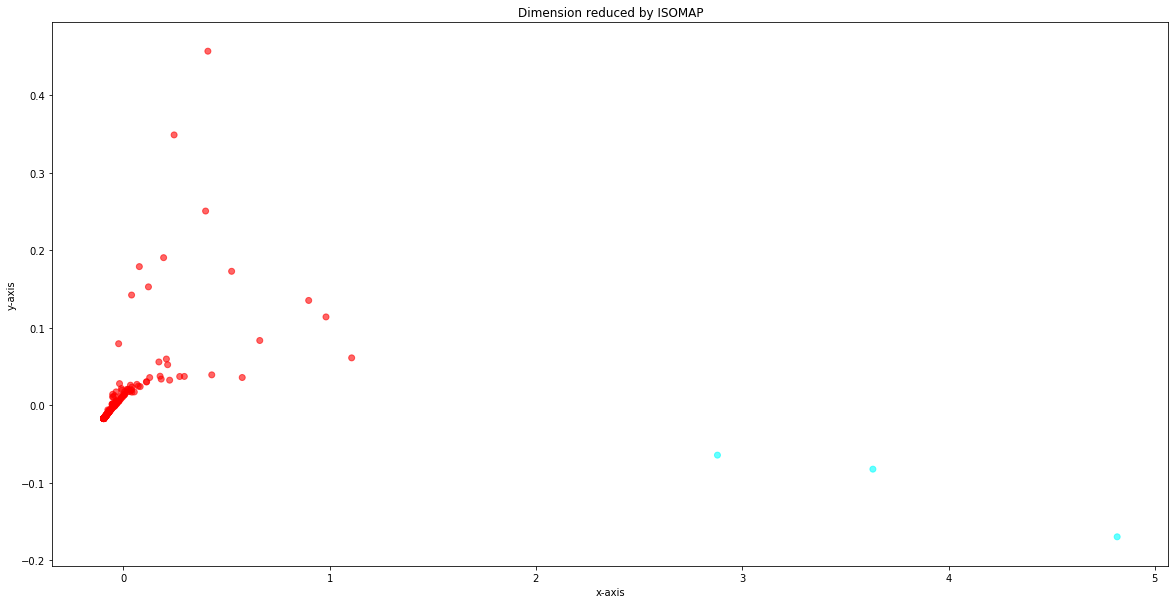

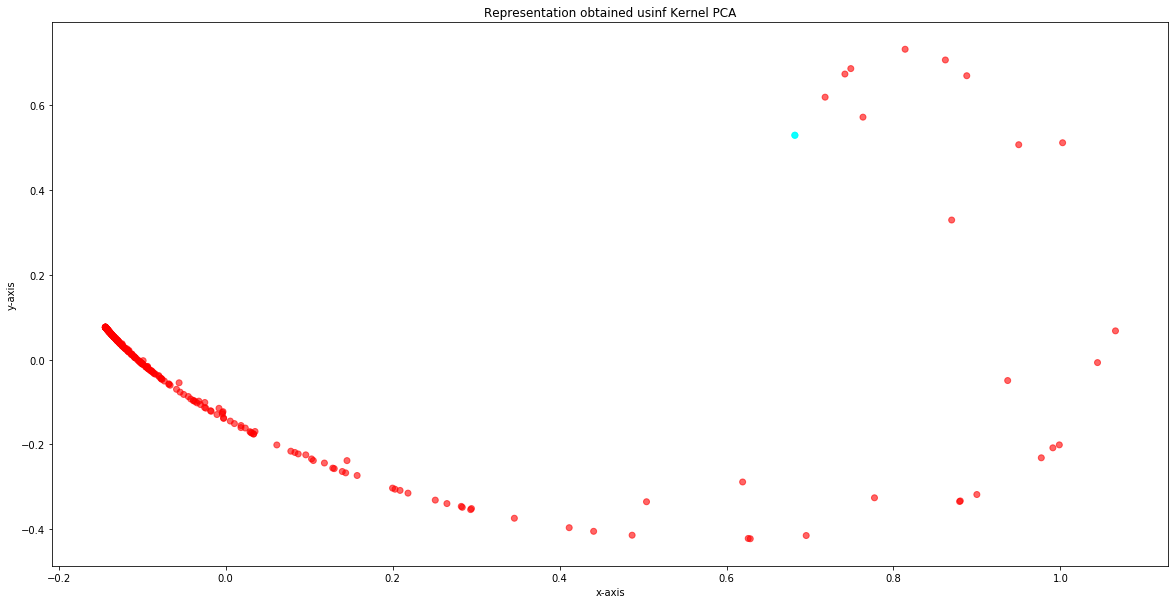

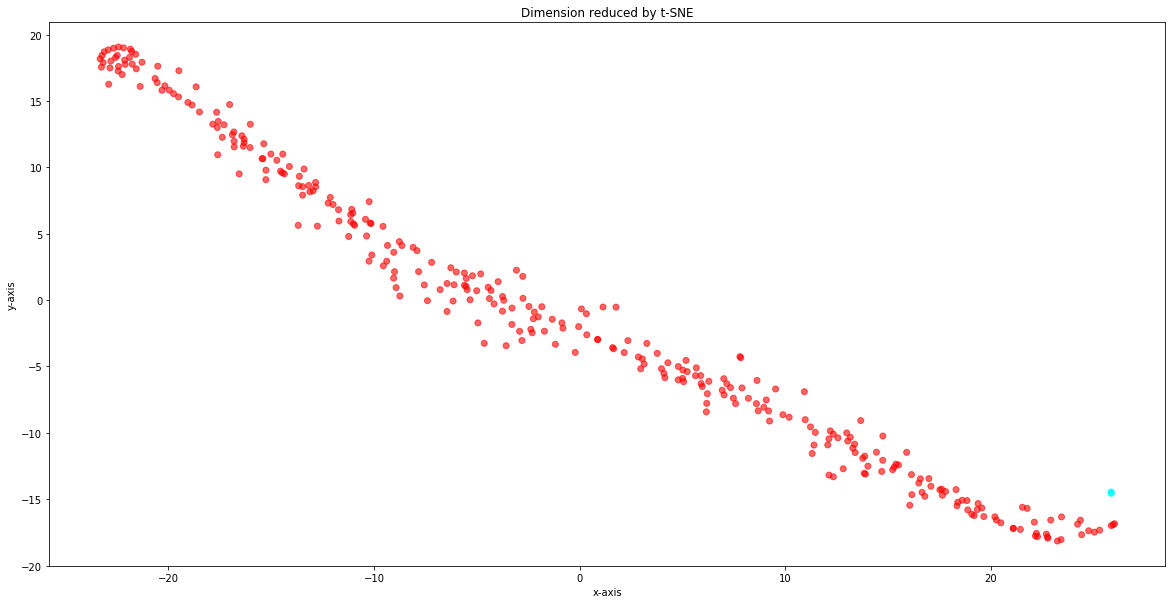

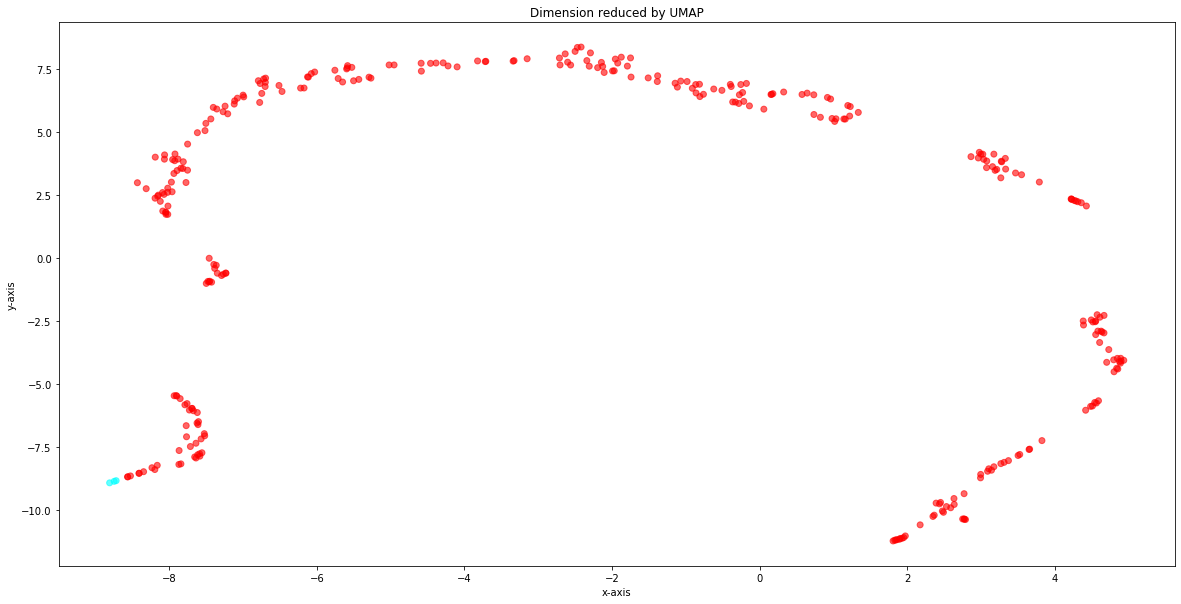

In [215]:
performAgglomerativeClustering(ncl=2, X=pivot.values, pivot=pivot)

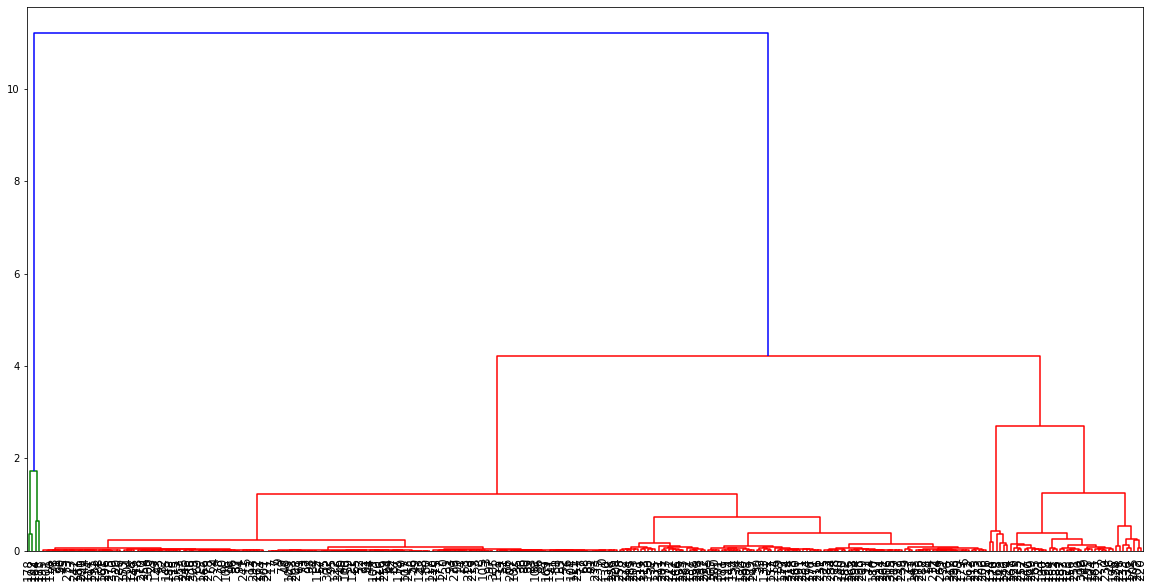

In [216]:
pivot = generate_quarter_pivot_matrix(4,aggTrain)
plot_scipy_edndogram(pivot = pivot)


silhouette sample on euclidean metric:  [0.96984509 0.97081893 0.93000799 0.97111049 0.97169945 0.97060734
 0.97068821 0.967843   0.97107847 0.967843   0.93507899 0.96910071
 0.9712696  0.97051127 0.97086861 0.9711586  0.97125724 0.96784572
 0.97133549 0.97036632 0.97181276 0.9123276  0.96554091 0.9718476
 0.97147621 0.96908977 0.92699919 0.9715591  0.9684573  0.96592432
 0.96245861 0.97131743 0.95179783 0.96397332 0.96500499 0.97039134
 0.97019471 0.96840573 0.97181734 0.97036986 0.96890713 0.97000721
 0.96919753 0.97151758 0.96944238 0.97169666 0.96789888 0.97023122
 0.96904625 0.96897575 0.96907341 0.97015158 0.96904739 0.97112749
 0.97143885 0.96857366 0.96906469 0.96861961 0.97006557 0.96882244
 0.97153259 0.96815188 0.97162036 0.97079154 0.96946074 0.96854978
 0.97054522 0.96928218 0.96967607 0.97171039 0.96926346 0.97183821
 0.96881674 0.96812364 0.96937041 0.97104548 0.9698808  0.96965523
 0.97176671 0.96797354 0.97024661 0.97009308 0.97162044 0.97032344
 0.96822963 0.96968501 

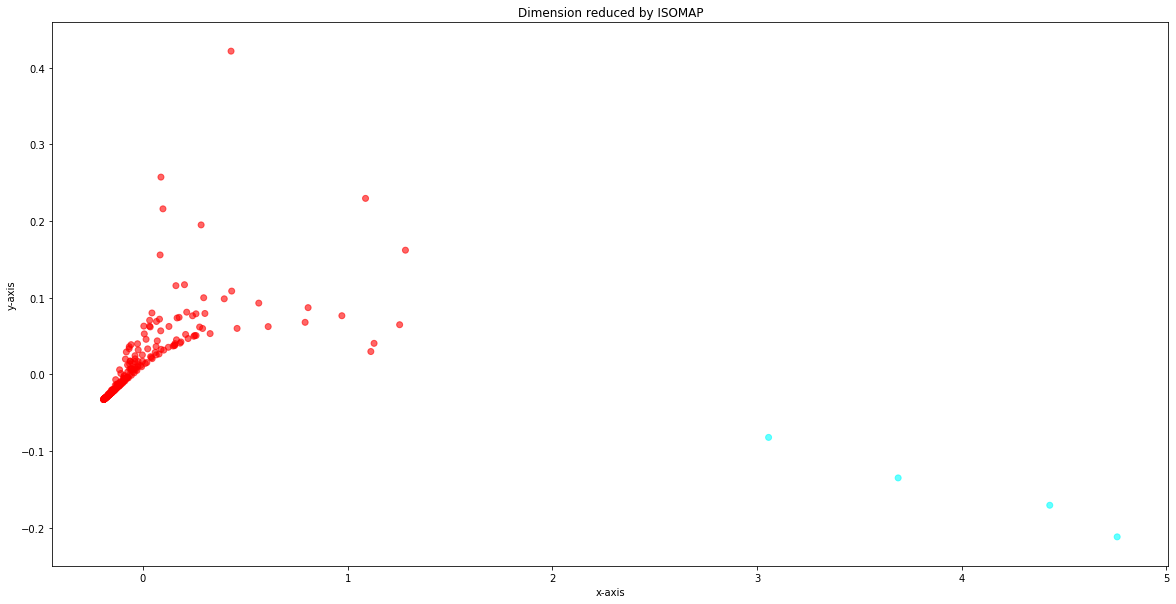

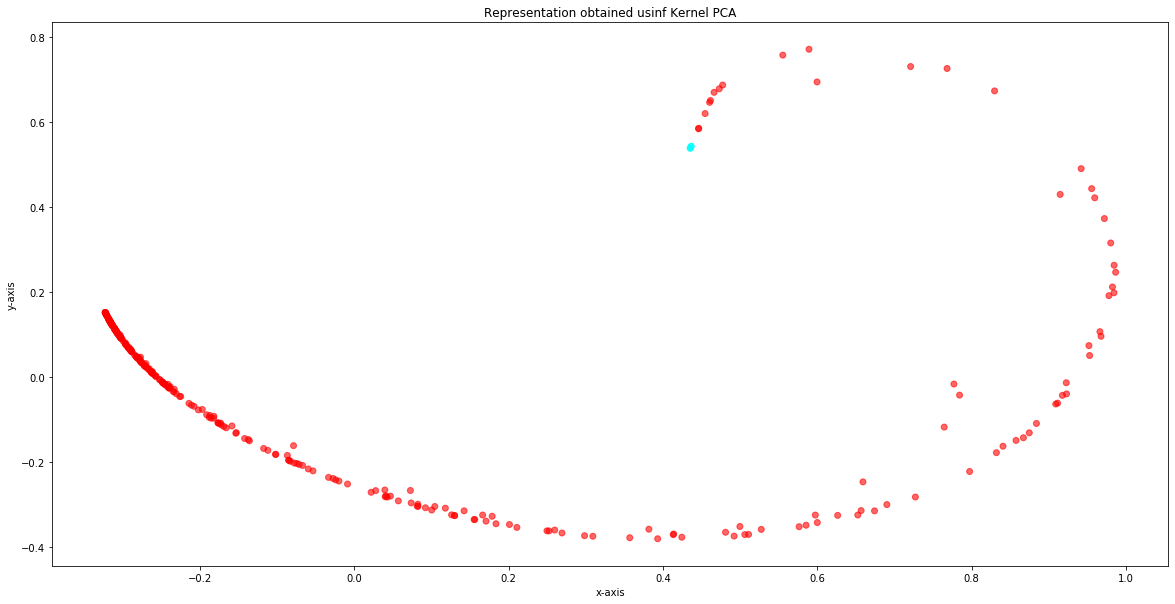

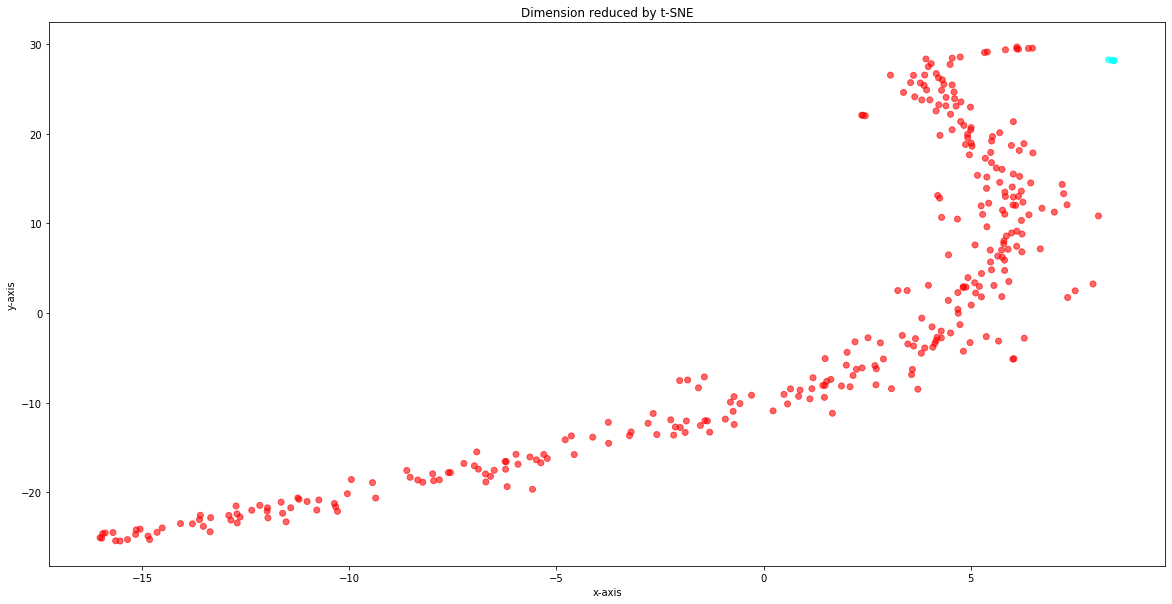

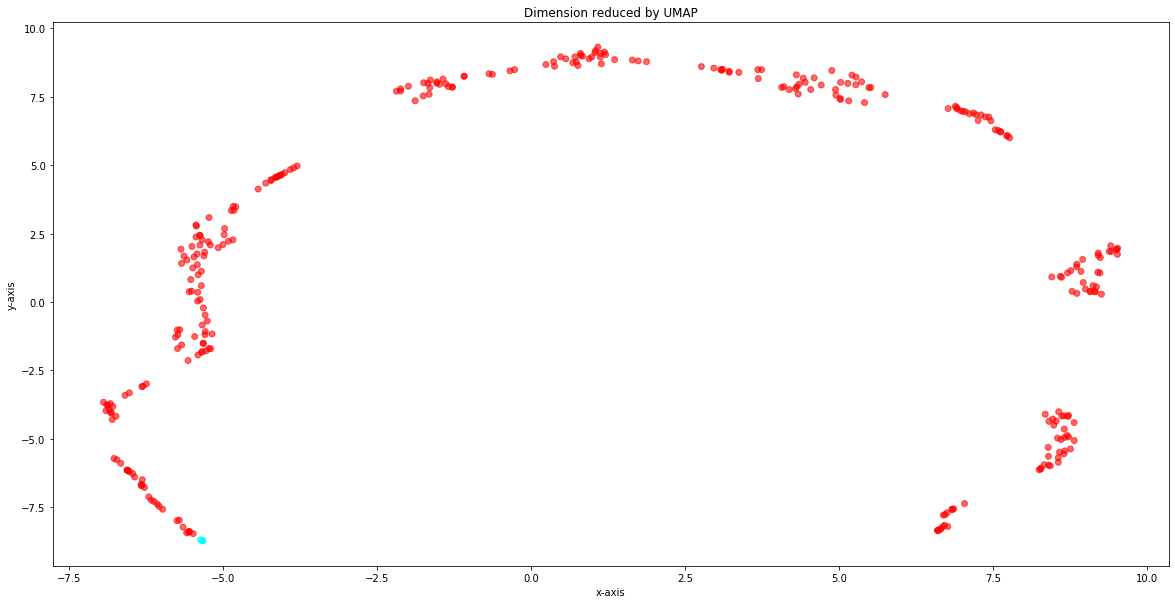

In [217]:
p = performAgglomerativeClustering(ncl=2, X=pivot.values, pivot=pivot)

In [218]:
p[p.index.get_level_values("cluster") ==1 ]

,hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
building_id,cluster,,,,,,,,,,,,,,,,,,,,,
1148,1,35266.563043,35003.648913,35461.445652,35152.430435,35375.336957,35913.896739,36100.629348,37777.940217,39160.496739,38825.749891,...,34957.283696,34559.608696,33927.821739,34572.347826,35012.816304,34780.230435,34768.771739,34928.755435,35215.102174,35207.455435
1159,1,28615.706522,27689.118478,27817.331522,28129.659783,28480.984783,29061.954348,30830.355435,32076.127174,32991.350000,33273.641304,...,30463.213043,30460.705435,29741.811957,29905.411957,28664.717391,28021.935870,28209.402174,28426.529348,28677.710870,28321.678261
1168,1,40646.739130,41013.586957,41486.413043,41759.510870,42273.097826,43622.282609,45819.293478,47572.010870,48305.706522,47042.119565,...,41804.347826,41156.250000,40336.956522,40822.010870,41033.967391,40618.206522,41364.130435,41718.750000,41673.913043,40316.576087
1197,1,45435.463043,45496.264130,46313.865217,46165.430435,46511.553261,46893.347826,47363.865217,48511.081522,48963.321739,48285.536957,...,44358.356522,44221.806522,44148.784783,44403.880435,44376.361957,44405.235870,44530.568478,44637.238043,45011.894565,45345.104348


# Dtw distance with Agglomerative

In [ ]:
dtwMatrix = generate_quarter_pivot_matrix(0, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix = generate_dtw_matrix(dtwMatrix.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix)

pivot generated


In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix, pivot=generate_quarter_pivot_matrix(0, aggTrain))b

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]

In [ ]:
dtwMatrix = generate_quarter_pivot_matrix(1, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix = generate_dtw_matrix(dtwMatrix.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix)

In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix, pivot=generate_quarter_pivot_matrix(0, aggTrain))b

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]

In [ ]:
dtwMatrix = generate_quarter_pivot_matrix(2, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix = generate_dtw_matrix(dtwMatrix.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix)

In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix, pivot=generate_quarter_pivot_matrix(0, aggTrain))b

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]

In [ ]:
dtwMatrix = generate_quarter_pivot_matrix(3, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix = generate_dtw_matrix(dtwMatrix.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix)

In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix, pivot=generate_quarter_pivot_matrix(0, aggTrain))b

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]

In [ ]:
dtwMatrix = generate_quarter_pivot_matrix(4, aggTrain)
#print(dtwMatrix)
print("pivot generated")
dtwMatrix = generate_dtw_matrix(dtwMatrix.values)
print("dis-similarity matrix generated.")
plot_scipy_edndogram(pivot = dtwMatrix)

In [ ]:
p = performAgglomerativeClustering(ncl=2, X=dtwMatrix, pivot=generate_quarter_pivot_matrix(0, aggTrain))b

In [ ]:
p[p.index.get_level_values("cluster") ==1 ]